<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Basic-Functions" data-toc-modified-id="Basic-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic Functions</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#DD-SIMCA-Overall-Model-(all-years)" data-toc-modified-id="DD-SIMCA-Overall-Model-(all-years)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DD-SIMCA Overall Model (all years)</a></span><ul class="toc-item"><li><span><a href="#All-analytes" data-toc-modified-id="All-analytes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>All analytes</a></span></li><li><span><a href="#Only->80%->LOD" data-toc-modified-id="Only->80%->LOD-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Only &gt;80% &gt;LOD</a></span></li><li><span><a href="#Top-k-variance" data-toc-modified-id="Top-k-variance-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Top k variance</a></span></li><li><span><a href="#Decorrelation-via-Hierarchical-Clustering" data-toc-modified-id="Decorrelation-via-Hierarchical-Clustering-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Decorrelation via Hierarchical Clustering</a></span></li></ul></li><li><span><a href="#PU-Learning" data-toc-modified-id="PU-Learning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PU Learning</a></span></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git
    !cd pychemauth; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import pychemauth

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import copy

shap.initjs()

Overview
--------
This notebook illustrates the analysis of stable isotope and trace element data for strawberries.  This data was provided by Nives Ogrinc and Lidija Strojnik.

Summary
-------------
* DD-SIMCA and Soft PLS-DA have similar TEFF ~ 0.77 with "accuracies" of ~83%.
* The DD-SIMCA model is "saturated" according to the learning curve.
* No temporal trends were detected - this analysis uses an imputation scheme with max(LOD(year)); since there was an instrumentation change, it is possible that datasets using imputatations whose LOD is a function of year might see a trend, but this is an artifact.
* (1) P and (2) Na are the most important features.
* PCA and LDA work pretty well and use P heavily.
* Other (discriminating) ML models can found which are very similar in performance (~82% accuracy on test set); very simple decision trees can be found with accuracies of ~ SIMCA TEFF; RF variants also good.
* Since authentication models (which are saturated) perform about as well as discrimination models (RF, etc.) it does not seem like these SITE measurements provide enough information to train ANY model to perform better.
* Outliers are very important - DD-SIMCA can be made to perform (in TEFF units) as well as a RF if one outlier was removed when only using (P, Na).  DD-SIMCA has some "built in" methods to handle this, so that could be considered a success; however the DT performs just as well and is arguably more interpretable

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

sys       : 3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]
json      : 2.0.9
shap      : 0.40.0
watermark : 2.3.0
imblearn  : 0.9.0
sklearn   : 1.0.2
pandas    : 1.3.4
seaborn   : 0.11.2
matplotlib: 3.5.1
numpy     : 1.21.5



# Basic Functions

In [366]:
from sklearn.model_selection import learning_curve

def plot_lc(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        random_state=42,
        shuffle=True, # If you set this to False you see an improvement suggesting there is a trend over time
        cv=cv,  
        n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.plot(
        train_sizes,
        train_mean,
        color="blue",
        marker="o",
        markersize=5,
        label="Training",
    )

    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha=0.15,
        color="blue",
    )

    plt.plot(
        train_sizes,
        test_mean,
        color="green",
        linestyle="--",
        marker="s",
        markersize=5,
        label="Cross-Validation",
    )

    plt.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha=0.15,
        color="green",
    )

    plt.grid()
    plt.xlabel("Number of training samples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()

In [5]:
# def impute_by_year(raw_df, lod_df, impute_elements):
#     np.random.seed(0)

#     X_raw = {}
#     for year in [2018, 2019, 2020]:
#         X = copy.copy(raw_df[raw_df['Harvest year'] == year])
#         lod = lod_df[lod_df['Harvest year'] == year]
#         for analyte in impute_elements:

#             def randomly_impute(x):
#                 if np.isnan(x): # NaN was recorded for < LOD
#                     return np.random.random()*float(lod[analyte])
#                 else:
#                     return x

#             X[analyte] = X[analyte].apply(randomly_impute)
#         X_raw[year] = X
        
#     return pd.concat([X_raw[yr] for yr in [2018, 2019, 2020]])

In [6]:
def impute_by_max(raw_df, lod_df, impute_elements):
    np.random.seed(0)

    X_raw = {}
    for year in [2018, 2019, 2020]:
        X = copy.copy(raw_df[raw_df['Harvest year'] == year])
        for analyte in impute_elements:
            lod = lod_df[analyte].max()

            def randomly_impute(x):
                if np.isnan(x): # NaN was recorded for < LOD
                    return np.random.random()*float(lod)
                else:
                    return x

            X[analyte] = X[analyte].apply(randomly_impute)
        X_raw[year] = X
        
    return pd.concat([X_raw[yr] for yr in [2018, 2019, 2020]])

In [337]:
def rename(x):
    if x == 'Authentic SLO':
        return 'Authentic'
    elif x == 'Test SLO':
        return 'Unknown'
    else:
        return x

In [383]:
def run(df_in, site_elements, relabel=False, show_extra=True):
    df = df_in.copy()
    
    if relabel:
        new_name = rename
    else:
        new_name = lambda x: x
    
    df['Origin'] = df['Origin'].apply(new_name)
    mask = (df['Origin'] == new_name('Authentic SLO')) | (df['Origin'] == new_name('Abroad')) # The Test SLO is unknown
    
    X_train, X_test, y_train, y_test = train_test_split(
        df[mask][site_elements].values,
        df[mask]['Origin'].values,
        test_size=0.30, 
        random_state=0,
        shuffle=True,
        stratify=df[mask]['Origin'].values
    )
    
    pipeline = imblearn.pipeline.Pipeline(steps=[
        # Insert other preprocessing steps here...
        # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class=new_name("Authentic SLO"), 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    param_grid = [{
        'simca__n_components':np.arange(1, 20, 2),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True]
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=5, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(
        X_train,
        y_train
    )
    
    # Plot
    fig, axes = plt.subplots(nrows=2 if show_extra else 1, ncols=2, figsize=(10,10 if show_extra else 5))
    axes = axes.flatten()

    # Training Set
    ax = axes[0]
    gs.best_estimator_.named_steps['simca'].model.visualize(
        X_train,
        y_train,
        ax=ax
    )
    ax.legend(loc='best')
    ax.set_title('Training Set')

    # Unseen test Set
    ax = axes[1]
    gs.best_estimator_.named_steps['simca'].model.visualize(
        X_test,
        y_test,
        ax=ax
    )
    ax.legend(loc='best')
    ax.set_title('Test Set')

    if show_extra:
        # Consider "abroad" only to see how well it performs
        ax = axes[2]
        gs.best_estimator_.named_steps['simca'].model.visualize(
            df[df['Origin'] == new_name('Abroad')][site_elements].values,
            df[df['Origin'] == new_name('Abroad')]['Origin'].values,
            ax=ax
        )
        ax.legend(loc='best')
        ax.set_title('{} Set (Total)'.format(new_name('Abroad')))

        # Consider "unknowns"
        ax = axes[3]
        gs.best_estimator_.named_steps['simca'].model.visualize(
            df[df['Origin'] == new_name('Test SLO')][site_elements].values,
            df[df['Origin'] == new_name('Test SLO')]['Origin'].values,
            ax=ax
        )
        ax.legend(loc='best')
        ax.set_title('{} Set'.format(new_name('Test SLO')))

    plt.tight_layout()

    train_score = gs.score(X_train, y_train) # Pretty good results on training

    test_score = gs.score(X_test, y_test) # Similar for test set

    return gs, train_score, test_score

In [8]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

def plot_decision_region(clf, X, y, resolution=0.02):
    markers = ('s', 'o', '^', 'v')
    colors = ('r', 'b', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min(), X[:,0].max()
    dx = 0.1*(x1_max - x1_min)
    x1_min -= dx
    x1_max += dx
    
    x2_min, x2_max = X[:,1].min(), X[:,1].max()
    dx = 0.1*(x2_max - x2_min)
    x2_min -= dx
    x2_max += dx
    
    enc = LabelEncoder()
    enc.fit(y)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = enc.transform(Z).reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y==c1, 0], y=X[y==c1, 1], alpha=0.4, c=colors[idx], edgecolor='black', marker=markers[idx], label=c1)
        
    plt.legend(loc='best')

# Load Data

In [278]:
raw_df = pd.read_csv('./data/DB_strawberries_revised_data_max_lod.csv') # Set to NaN if < max(LOD)
lod_df = pd.read_csv('./data/DB_strawberries_revised_lod.csv')

In [279]:
lod_df # Limits of Detection for each year

,Sample type,Harvest year,18O,13C,15N,34S,Na,Mg,Al,P,...,As,Se,Rb,Sr,Mo,Cd,Cs,Ba,Hg,Pb
0,LOD,2018,NaN,NaN,NaN,NaN,2.4,0.0020,2.5,0.00045,...,3.0,2.5,0.015,0.130,10.0,1.00,1.0,0.045,0.4,15
1,LOD,2019,NaN,NaN,NaN,NaN,2.4,0.0020,2.5,0.00045,...,3.0,2.5,0.015,0.130,10.0,1.00,1.0,0.045,0.4,15
2,LOD,2020,NaN,NaN,NaN,NaN,1.1,0.0016,3.2,0.00030,...,1.7,3.0,0.173,0.173,3.5,0.25,0.6,0.173,0.3,10


In [280]:
site_elements = lod_df.columns.drop(['Sample type', 'Harvest year']).tolist() # Extract SITE labels

In [281]:
raw_df = raw_df[['Harvest year', 'Origin', 'Country'] + site_elements] # Reduce data frame to what we care about

In [282]:
# Which columns do we impute?  SI ratios do not have a LOD so ignore those.
impute_elements = lod_df.columns.drop(['Sample type', 'Harvest year', '18O', '13C', '15N', '34S'])

In [283]:
df = impute_by_max(raw_df, lod_df, impute_elements)

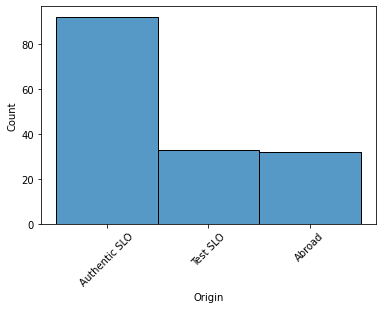

In [284]:
plt.figure()
sns.histplot(df, x='Origin')
_ = plt.xticks(rotation=45)

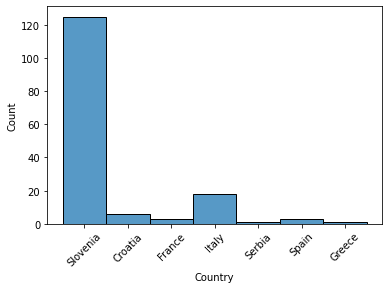

In [16]:
plt.figure()
sns.histplot(df, x='Country')
_ = plt.xticks(rotation=45)

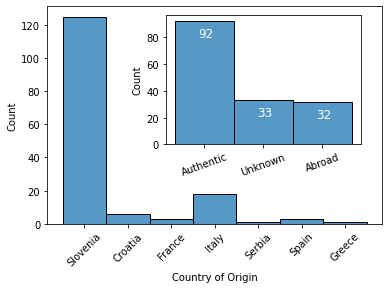

In [328]:
# For manuscript

df_tmp = df.copy()

df_tmp['Origin'] = df_tmp['Origin'].apply(rename)

fig = plt.figure()
sns.histplot(df_tmp, x='Country')
_ = plt.xticks(rotation=45)
plt.xlabel('Country of Origin')

ax = fig.add_axes([.4,.4,.45,.45])
plt.xticks(rotation=20)
sns.histplot(df_tmp, x='Origin', ax=ax)
plt.xlabel('')
plt.text(-0.1, 80, '92', fontsize=12, color='white')
plt.text(-0.1+1, 21, '33', fontsize=12, color='white')
plt.text(-0.1+2, 20, '32', fontsize=12, color='white')

plt.savefig('fig1.png', dpi=300, bbox_inches='tight')

# DD-SIMCA Overall Model (all years)

In [17]:
from pychemauth.classifier.simca import SIMCA_Classifier

## All analytes

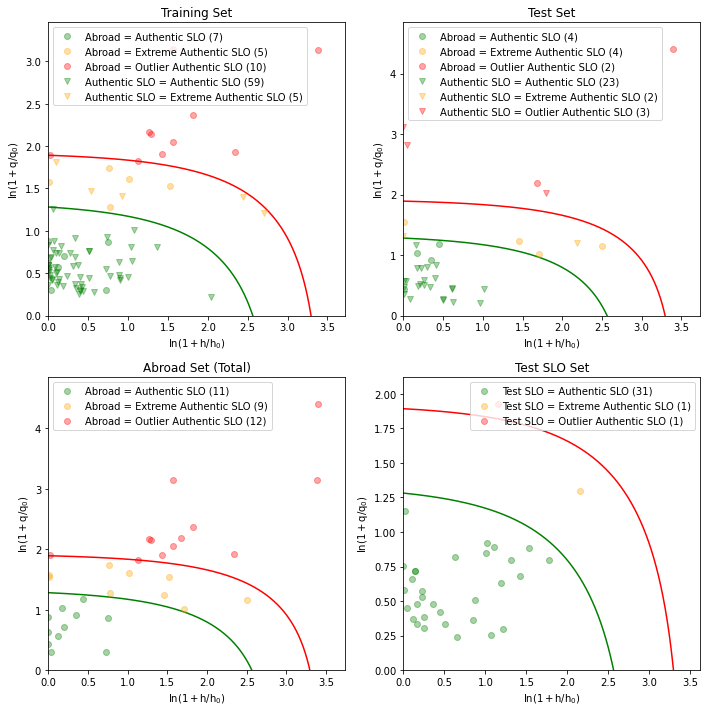

In [18]:
gs, _, _ = run(df, site_elements)

In [19]:
gs.best_params_

{'simca__alpha': 0.05,
 'simca__n_components': 1,
 'simca__scale_x': True,
 'simca__style': 'dd-simca'}

Text(0, 0.5, 'TEFF')

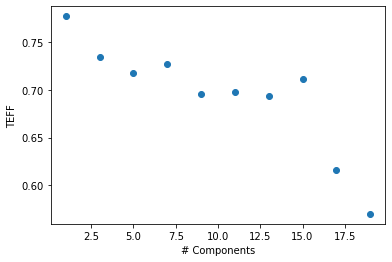

In [20]:
teff = gs.cv_results_['mean_test_score']
n = [d['simca__n_components'] for d in gs.cv_results_['params']]
plt.figure()
plt.plot(n, teff, 'o')
plt.xlabel('# Components')
plt.ylabel('TEFF')

In [21]:
# On the entire dataset...
mask = (df['Origin'] == 'Authentic SLO') | (df['Origin'] == 'Abroad')
gs.score(
    df[mask][site_elements].values,
    df[mask]['Origin'].values
)

0.7647996327541414

In [22]:
gs.best_estimator_.named_steps['simca'].TEFF

0.7647996327541414

In [23]:
gs.best_estimator_.named_steps['simca'].TSNS

0.8913043478260869

In [24]:
gs.best_estimator_.named_steps['simca'].TSPS # The "abroad" class should not be considered authentic, but performs quite poorly

0.65625

In [25]:
a = df[mask][site_elements].values
b = df[mask]['Origin'].values

mask2 = b == 'Authentic SLO'

# Indeed TSNS is the number of Auth SLO predicted to be Auth SLO
print(np.sum(gs.best_estimator_.named_steps['simca'].predict(a[mask2,:])) / np.sum(mask2))

# Indeed TSPS is the number of Abroad (correctly) not predicted to be Auth SLO
print(np.sum(~gs.best_estimator_.named_steps['simca'].predict(a[~mask2,:])) / np.sum(~mask2))

0.8913043478260869
0.65625


In [26]:
# Since this SIMCA model is trained on one positive class and all others are considered a single negative class
# we can compute an accuracy (there is no possibility of multiple assignments here) as if each of these were
# their own label.
correct_predictions = np.sum(~gs.best_estimator_.named_steps['simca'].predict(a[~mask2,:])) + \
    np.sum(gs.best_estimator_.named_steps['simca'].predict(a[mask2,:]))

# Pseudo-Accuracy (n_correct/n_total)
correct_predictions / a.shape[0]

# Note that this uses the entire data set - the test/train split was done inside the run() function

0.8306451612903226

Text(20.625, 0.5, 'TEFF')

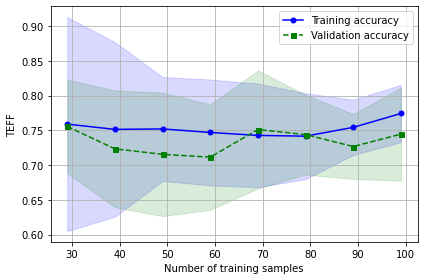

In [29]:
# TEFF = TSNS in the case where no alternatives presented
# plot_lc(
#     estimator=SIMCA_Classifier(
#             n_components=1, 
#             alpha=0.05, 
#             scale_x=True, 
#             style='dd-simca', 
#             target_class="Authentic SLO",
#             use='TEFF'
#         ), 
#     X=df[df['Origin'] == 'Authentic SLO'][site_elements].values, 
#     y=df[df['Origin'] == 'Authentic SLO']['Origin'].values, 
#     train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
#     cv=5)

# More data does not improve the model!  This is saturated - SIMCA simply cannot perform better than it already is
plot_lc(
    estimator=SIMCA_Classifier(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            target_class="Authentic SLO",
            use='TEFF'
        ), 
    X=df[mask][site_elements].values, 
    y=df[mask]['Origin'].values, 
    train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    cv=5)
plt.gca().set_ylabel('TEFF')

## Only >80% >LOD

In [30]:
raw_df[raw_df['Origin'] == 'Authentic SLO'].isna().sum()

Harvest year     0
Origin           0
Country          0
18O              0
13C              0
15N              0
34S              0
Na               2
Mg               0
Al              21
P                0
S                0
K                0
Ca               0
V               12
Cr              49
Mn               0
Fe               0
Co               0
Ni              10
Cu               0
Zn               0
As              19
Se              36
Rb               0
Sr               0
Mo               0
Cd               4
Cs               5
Ba               0
Hg              43
Pb              70
dtype: int64

In [31]:
bad_analytes = raw_df[raw_df['Origin'] == 'Authentic SLO'].isna().sum() / raw_df[raw_df['Origin'] == 'Authentic SLO'].shape[0] > 0.2
bad_analytes = bad_analytes.index[bad_analytes]

In [32]:
bad_analytes 
# I have also removed Al and As in addition to those flagged in the original data provided
# However, in the end, Al and As did not really play an significant role

Index(['Al', 'Cr', 'As', 'Se', 'Hg', 'Pb'], dtype='object')

In [409]:
df = impute_by_max(raw_df.drop(bad_analytes, axis=1), 
            lod_df, 
            impute_elements.drop(bad_analytes)
           ) 

In [340]:
trimmed_elements = [e for e in site_elements if e not in bad_analytes]

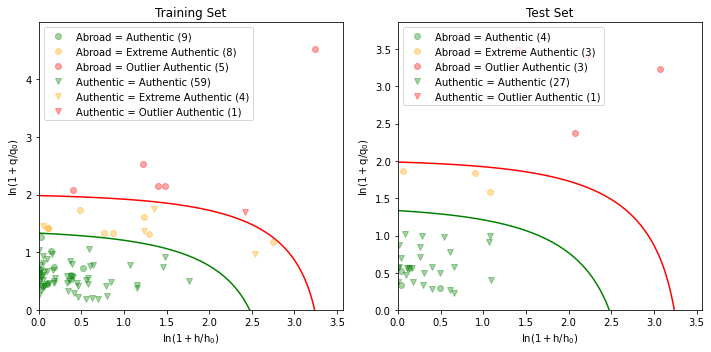

In [349]:
gs = run(df, trimmed_elements, relabel=True, show_extra=False)
# plt.savefig('fig2.png', dpi=300, bbox_inches='tight')

savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


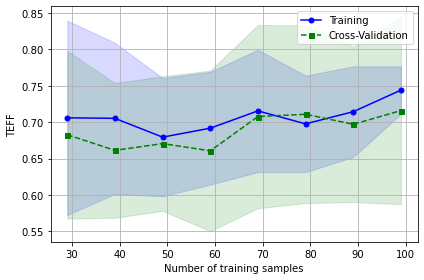

In [367]:
mask = (df['Origin'] == 'Authentic SLO') | (df['Origin'] == 'Abroad')

plot_lc(
    estimator=SIMCA_Classifier(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            target_class="Authentic SLO",
            use='TEFF'
        ), 
    X=df[mask][trimmed_elements].values, 
    y=df[mask]['Origin'].values, 
    train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    cv=5)
plt.gca().set_ylabel('TEFF')

plt.savefig('fig3.png', dpi=300, bbox_to_inches='tight')

## Top k variance

In [37]:
df = impute_by_max(raw_df,
            lod_df,
            impute_elements
           ) 

In [38]:
top_k = sorted([[k,v] for k,v in dict(df[site_elements].std()).items()], key=lambda x:x[1], reverse=True)
top_k # note that Pb, Cr, Al, As are in the top 10 (which are considered poorly sampled)

[['Ni', 367.0097429049077],
 ['Mo', 317.32754039544074],
 ['Cd', 75.18741119168615],
 ['Pb', 45.33206635176837],
 ['Na', 39.025353422856995],
 ['Co', 36.55210037004289],
 ['Cr', 31.914214122490005],
 ['Al', 29.11160025414232],
 ['As', 25.496098842550985],
 ['V', 22.650474345117168],
 ['Mn', 12.76184975092059],
 ['Cs', 11.987586168486217],
 ['Fe', 8.942000742657884],
 ['Se', 7.614877310245644],
 ['Zn', 3.8277750898996667],
 ['Ba', 3.7228792709419483],
 ['Sr', 3.70720309612473],
 ['Rb', 3.6658701171615924],
 ['K', 3.1433371862910895],
 ['Hg', 3.076149000270583],
 ['Cu', 2.3050119617060054],
 ['34S', 2.2931130916761346],
 ['15N', 2.2898319979039647],
 ['18O', 2.135177705330965],
 ['13C', 0.8103520924639227],
 ['Ca', 0.4654597304415701],
 ['P', 0.4178267689466944],
 ['Mg', 0.2650024637177293],
 ['S', 0.12027613894963604]]

In [39]:
# Let's just take the top 10
trimmed_elements = [e[0] for e in top_k[:10]]


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the numb

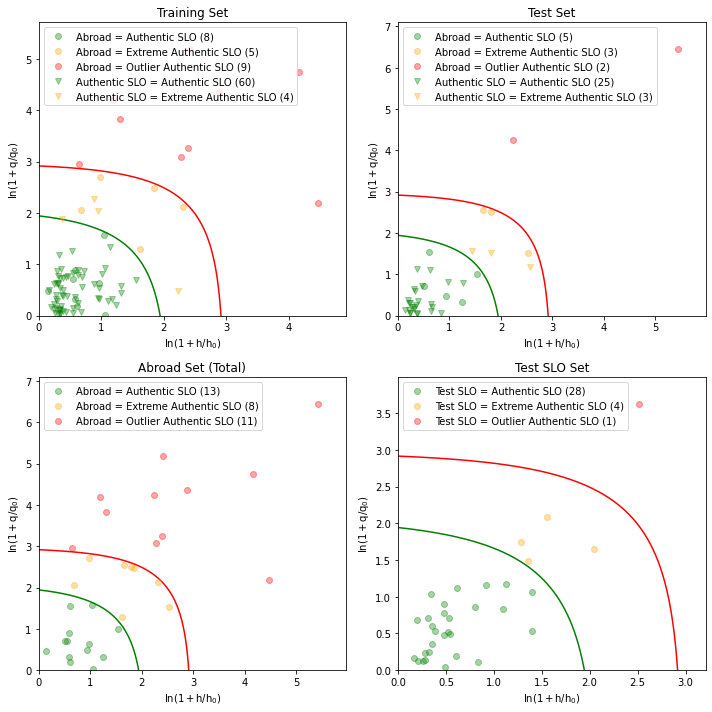

In [40]:
gs = run(df, trimmed_elements)

# Decorrelation via Hierarchical Clustering 

In [49]:
import sys
sys.path.append('../../../')
import ml_inspector
from sklearn.preprocessing import StandardScaler

In [50]:
df = impute_by_max(raw_df.drop(bad_analytes, axis=1), 
            lod_df, 
            impute_elements.drop(bad_analytes)
           )
trimmed_elements = [e for e in site_elements if e not in bad_analytes]

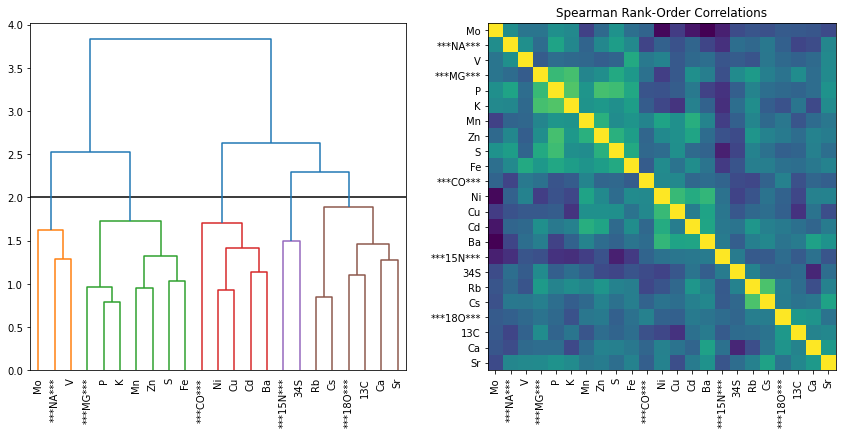

In [51]:
X_raw = df[trimmed_elements].values
ss = StandardScaler()
selected_features, cluster_id_to_feature_ids = ml_inspector.data.InspectData.cluster_collinear(
    ss.fit_transform(X_raw),
    figsize=(12, 6),
    display=True,
    t=2,
    feature_names=trimmed_elements
)

In [52]:
df[selected_features]

,18O,15N,Na,Mg,Co
0,-3.779856,3.771404,3.486906,1.492016,71.263260
1,-3.552212,4.230576,4.083309,1.495968,92.296047
2,-4.060171,3.224171,5.857624,1.534252,56.866964
3,-4.463703,4.635560,3.836591,1.435963,76.015118
4,-4.018499,5.072492,3.854590,1.313191,58.855611
...,...,...,...,...,...
152,0.125997,2.429859,49.911555,1.020172,77.815081
153,-2.124287,4.636597,8.603010,1.130143,32.135400
154,-1.424029,3.766597,11.428437,1.077949,61.798675
155,-1.943721,4.102685,26.804935,1.082529,27.746945



40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the numb

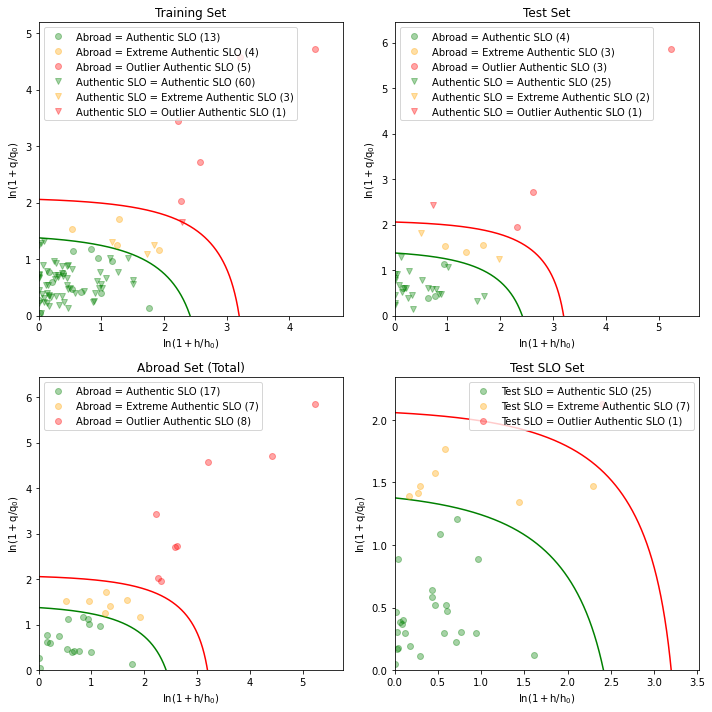

In [53]:
gs = run(df, selected_features)

In [54]:
gs

(GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
              error_score=0,
              estimator=Pipeline(steps=[('simca',
                                         SIMCA_Classifier(n_components=7,
                                                          target_class='Authentic '
                                                                       'SLO'))]),
              n_jobs=-1,
              param_grid=[{'simca__alpha': [0.05],
                           'simca__n_components': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                           'simca__scale_x': [True],
                           'simca__style': ['dd-simca']}]),
 0.6192921178835779,
 0.7319250547113999)

In [48]:
# The abroad test has actually gotten worse. 

# Analyze temporal trends in analytes

In [55]:
df = impute_by_max(raw_df.drop(bad_analytes, axis=1), 
            lod_df, 
            impute_elements.drop(bad_analytes)
           ) 
trimmed_elements = [e for e in site_elements if e not in bad_analytes]

## Individual Trends

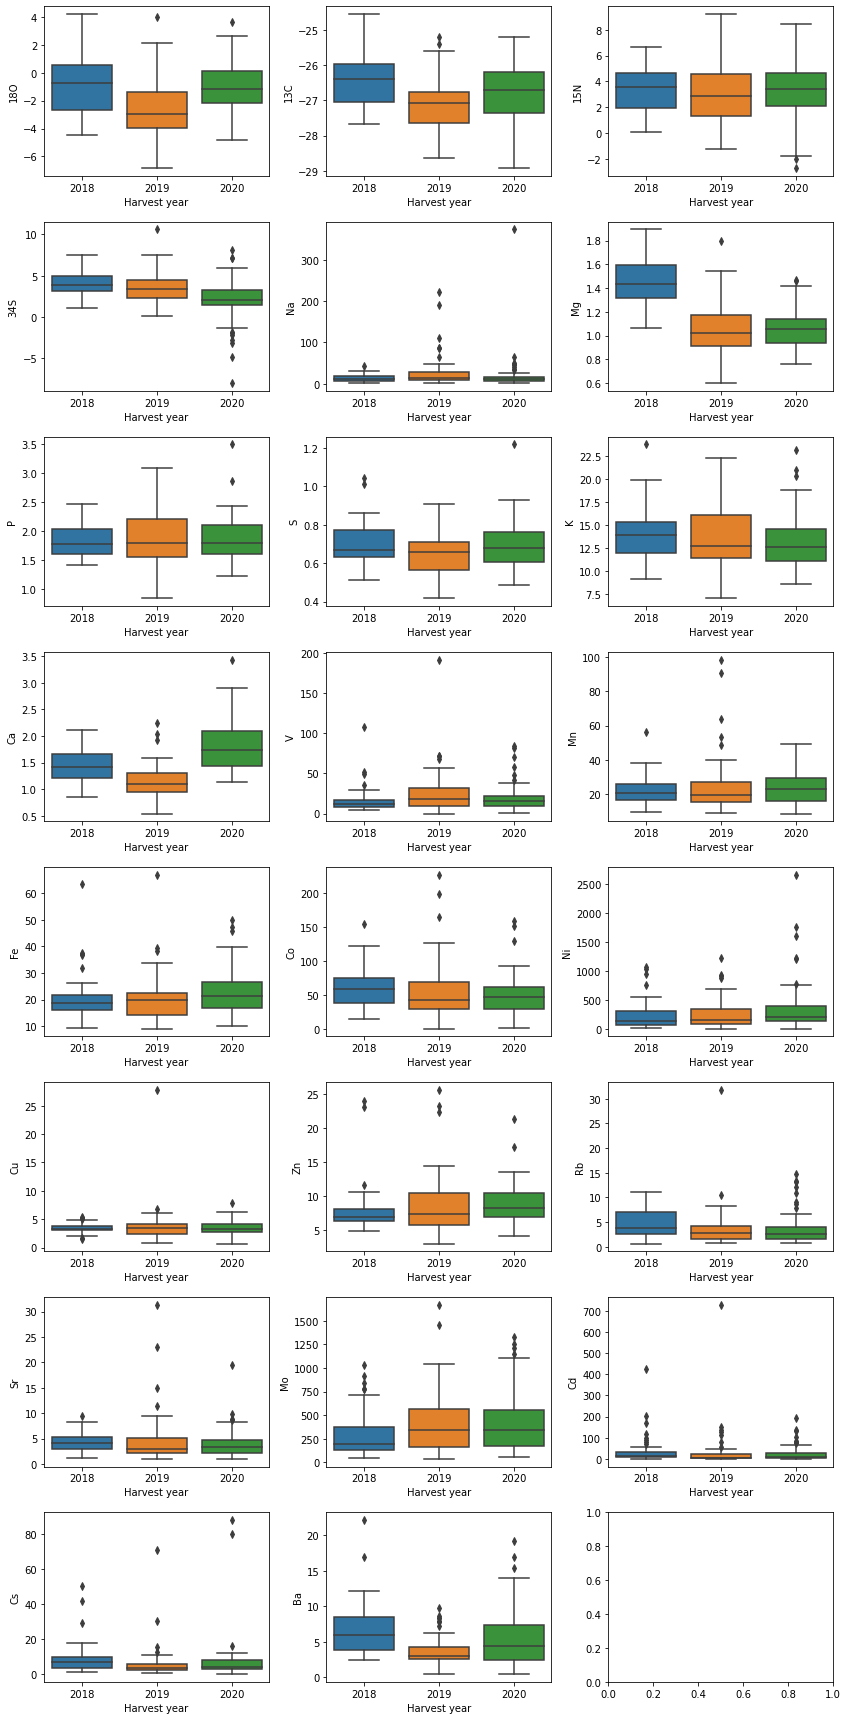

In [56]:
# Maybe Mg is decreasing, but other than that I don't see anything that really jumps out at me

fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(12,24))
for analyte,ax in zip(trimmed_elements, axes.ravel()):
    sns.boxplot(data=df, y=analyte, x='Harvest year', ax=ax)
plt.tight_layout()

## Models for Individual Years

### 2018


4 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the number

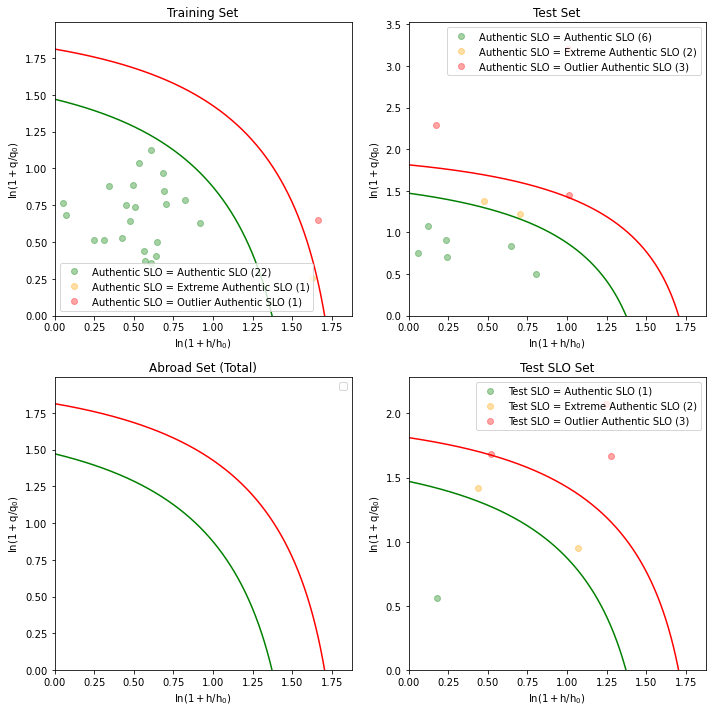

In [57]:
# There are no "Abroad" samples from 2018
gs = run(df[df['Harvest year'] == 2018], trimmed_elements)

### 2019


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the numb

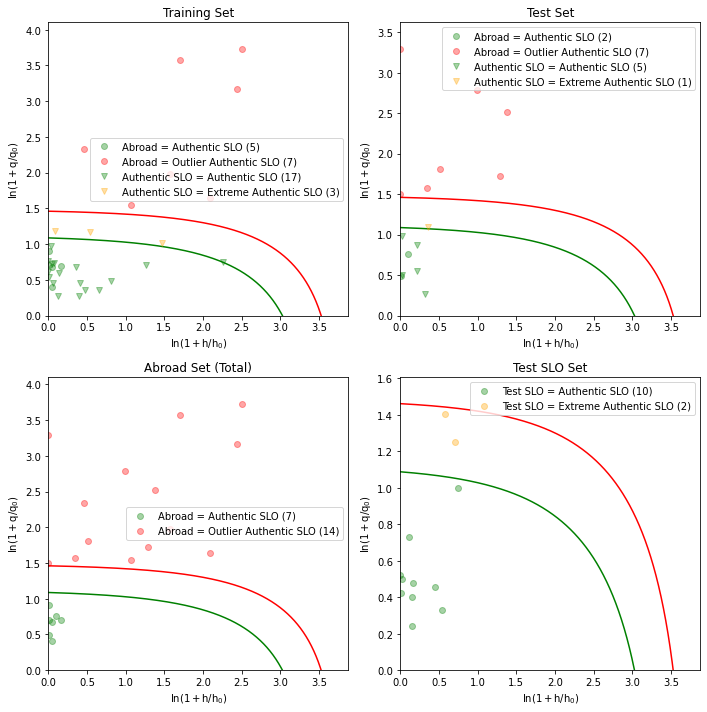

In [58]:
gs = run(df[df['Harvest year'] == 2019], trimmed_elements)

### 2020


7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the number

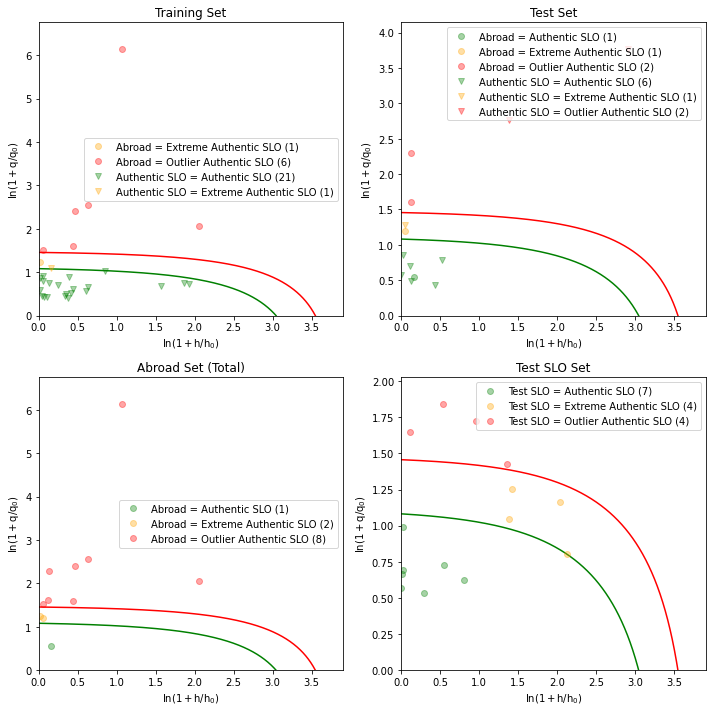

In [59]:
gs = run(df[df['Harvest year'] == 2020], trimmed_elements)

# Conventional ML

In [61]:
df = impute_by_max(raw_df.drop(bad_analytes, axis=1), 
            lod_df, 
            impute_elements.drop(bad_analytes)
           ) 
df_trim = df[(df['Origin'] == 'Authentic SLO') | (df['Origin'] == 'Abroad')].drop(['Harvest year', 'Country'], axis=1)

X_raw = df_trim.drop(['Origin'], axis=1).values
y_raw = df_trim['Origin'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y_raw,
    test_size=0.30, 
    random_state=42,
    shuffle=True,
    stratify=y_raw
)

# Scale the data based on the training set chosen
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [62]:
%matplotlib notebook

## PCA

In [63]:
from sklearn.decomposition import PCA

pca = PCA()
_ = pca.fit(X_train, y_train)

In [64]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('PCA')

X_new_pca = pca.transform(X_train)
for i,loc in enumerate(np.unique(y_train)):
    x_ = X_new_pca[y_train == loc,:]
    ax.scatter(x_[:,0], x_[:,1], label='Train/'+loc, color='C{}'.format(i))
    
ax.set_xlabel('PC {} ({}%)'.format(1, '%.1f'%(100*pca.explained_variance_ratio_[0])))
ax.set_ylabel('PC {} ({}%)'.format(2, '%.1f'%(100*pca.explained_variance_ratio_[1])))
    
X_new_pca = pca.transform(X_test)
for i,loc in enumerate(np.unique(y_test)):
    x_ = X_new_pca[y_test == loc,:]
    ax.scatter(x_[:,0], x_[:,1], label='Test/'+loc, color='C{}'.format(i+2))


plt.legend(loc='best')

<IPython.core.display.Javascript object>

In [65]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('PCA')

X_new_pca = pca.transform(X_train)
for i,loc in enumerate(np.unique(y_train)):
    x_ = X_new_pca[y_train == loc,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label='Train/'+loc, color='C{}'.format(i))
    
ax.set_xlabel('PC {} ({}%)'.format(1, '%.1f'%(100*pca.explained_variance_ratio_[0])))
ax.set_ylabel('PC {} ({}%)'.format(2, '%.1f'%(100*pca.explained_variance_ratio_[1])))
ax.set_zlabel('PC {} ({}%)'.format(3, '%.1f'%(100*pca.explained_variance_ratio_[2])))
    
X_new_pca = pca.transform(X_test)
for i,loc in enumerate(np.unique(y_test)):
    x_ = X_new_pca[y_test == loc,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label='Test/'+loc, color='C{}'.format(i+2))


plt.legend(loc='best')

<IPython.core.display.Javascript object>

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3))

ax.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax.set_ylabel('Total Explained Variance')
ax.set_xlabel('Eigenvector Index')
ax.set_title('PCA')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'PCA')

In [67]:
# P is the most important measurement here for PC 1 (but not others)

pc_idx = 0

importances = sorted(zip(df_trim.drop(['Origin'], axis=1).columns, 
                         pca.components_[pc_idx]), 
                     reverse=True, key=lambda x:np.abs(x[1]))

fig, ax = plt.subplots(1, 1, figsize=(18,4))
importance_df = pd.DataFrame(
    columns=['Feature', 'Scaling'],
    data=importances,
)
plt.xticks(rotation=45)
_ = sns.barplot(data=importance_df, x='Feature', y='Scaling', ax=ax, orient='v')

ax.set_xlabel('Feature')
ax.set_ylabel('PCA Coefficient on PC{}'.format(pc_idx+1))

<IPython.core.display.Javascript object>

Text(0, 0.5, 'PCA Coefficient on PC1')

## LDA

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(solver='svd', shrinkage=None, n_components=1)
lda.fit(X_train, y_train)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LDA')

X_new_lda = lda.transform(X_train)
for i,origin in enumerate(['Authentic SLO', 'Abroad']):
    x_ = X_new_lda[y_train == origin,:]
    ax.scatter(x=np.arange(len(x_)), y=x_[:,0], label='Train/'+origin, color='C{}'.format(i))
    
X_new_lda = lda.transform(X_test)
for i,origin in enumerate(['Authentic SLO', 'Abroad']):
    x_ = X_new_lda[y_test == origin,:]
    ax.scatter(x=np.arange(len(x_)), y=x_[:,0], label='Train/'+origin, color='C{}'.format(i+2))
    
ax.set_xlabel('Observation Index')
ax.set_ylabel('LD1 Coordinate')
plt.legend(loc='best')

guess = 0.25
ax.axhline(guess, color='r')

<IPython.core.display.Javascript object>

In [69]:
lda.score(X_train, y_train)

0.9418604651162791

In [70]:
lda.score(X_test, y_test)

0.868421052631579

## SVC

In [71]:
from sklearn.svm import SVC

In [72]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("svc", SVC(C=1.0))
])

param_grid = [{
    'svc__C':[0.01, 0.1, 1.0, 10.0, 100.0],
    'svc__kernel':['rbf', 'poly', 'linear', 'sigmoid'],
    'svc__gamma':['auto', 'scale'],
    'svc__coef0':[0.01, 0.1, 1.0, 10.0, 100.0],
    'svc__degree':[1, 2, 3, 4, 5],
    'svc__shrinking':[True, False],
    'svc__class_weight':['balanced', None],
    'svc__random_state':[42]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(
    X_train, 
    y_train
)

In [73]:
gs.best_params_

{'svc__C': 0.1,
 'svc__class_weight': 'balanced',
 'svc__coef0': 0.1,
 'svc__degree': 1,
 'svc__gamma': 'auto',
 'svc__kernel': 'sigmoid',
 'svc__random_state': 42,
 'svc__shrinking': True}

In [74]:
gs.score(X_train, y_train)

0.8837209302325582

In [75]:
gs.score(X_test, y_test)

0.8421052631578947

## Random Forest ("State-of-the-Art")

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("rf", RandomForestClassifier(n_estimators=1.0))
])

param_grid = [{
    'rf__n_estimators':[10, 100, 200],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 3, 5, 10, 20, None],
    'rf__min_samples_leaf':[1, 2, 3],
    'rf__class_weight':['balanced', 'balanced_subsample', None],
    'rf__random_state':[42]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(
    X_train, 
    y_train
)

In [78]:
gs.best_params_ # Ensemble of fairly shallow trees!

{'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': 3,
 'rf__min_samples_leaf': 2,
 'rf__n_estimators': 100,
 'rf__random_state': 42}

In [79]:
gs.score(X_train, y_train)

0.9883720930232558

In [80]:
gs.score(X_test, y_test) # On par with others

0.8421052631578947

In [81]:
forest = gs.best_estimator_.named_steps['rf']
columns = df_trim.drop(['Origin'], axis=1).columns
importances = sorted(list(zip(columns, forest.feature_importances_)), key=lambda x:x[1], reverse=True)

fig, ax = plt.subplots(1, 1, figsize=(18,4))
importance_df = pd.DataFrame(
    columns=['Feature', 'Importance'],
    data=importances,
)
plt.xticks(rotation=45)
_ = sns.barplot(data=importance_df, x='Feature', y='Importance', ax=ax, orient='v')

ax.set_xlabel('Feature')
ax.set_ylabel('RF Feature Importance')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'RF Feature Importance')

In [82]:
# RF suggests (primary) P, and (secondary) Na, Ba, K, Mo, and Sr are the most important

## Decision Tree + JSD

In [83]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[1], # Let's see how just a "stump" performs
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(
    X_train, 
    y_train
)

In [85]:
gs.score(X_train, y_train)

0.872093023255814

In [86]:
gs.score(X_test, y_test) # BEST SO FAR!

0.868421052631579

In [87]:
gs.best_params_ 

{'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': 1,
 'dt__min_samples_leaf': 1,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

<IPython.core.display.Javascript object>


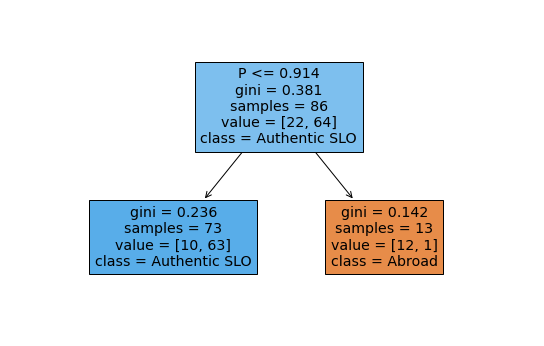

In [88]:
from sklearn import tree

fig = plt.figure()
_ = tree.plot_tree(gs.best_estimator_.named_steps['dt'], 
                   feature_names=df_trim.drop('Origin', axis=1).columns,  
                   class_names=np.unique(y_train),
                   impurity=True,
                   proportion=False,
                   filled=True)

# Remember this is in scaled units and using an internal balancing protocol

<IPython.core.display.Javascript object>


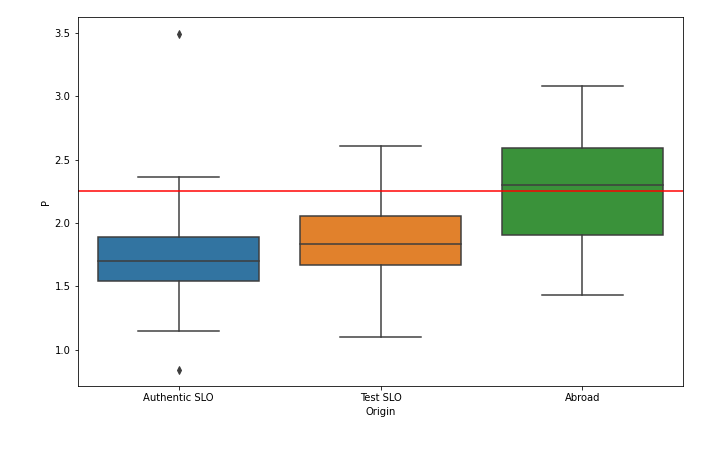

In [89]:
plt.figure()
sns.boxplot(data=df, y='P', x='Origin')
plt.tight_layout()

idx = np.where(df_trim.drop(['Origin'], axis=1).columns == 'P')[0][0]
tree_split = 0.914
cutoff = tree_split*ss.scale_[idx] + ss.mean_[idx] # In original units
plt.axhline(cutoff, color='r')


In [90]:
cutoff

2.2510275929184367

In [91]:
# Slovenian strawberries have a fairly unique (lower) level of P compared to the abroad samples
# The boxplot above suggests there is maybe a better level to use as the cutoff, but the tree is trained using
# balancing, etc. and is based on the proportion of samples seen.

In [92]:
from ml_utils.sklearn_ext.feature_selection import JensenShannonDivergence

In [93]:
jsd = JensenShannonDivergence(
    per_class=True, 
    feature_names=df_trim.drop(['Origin'], axis=1).columns,
    bins=25,
    robust=True
)

In [94]:
_ = jsd.fit(X_train, y_train)

<IPython.core.display.Javascript object>


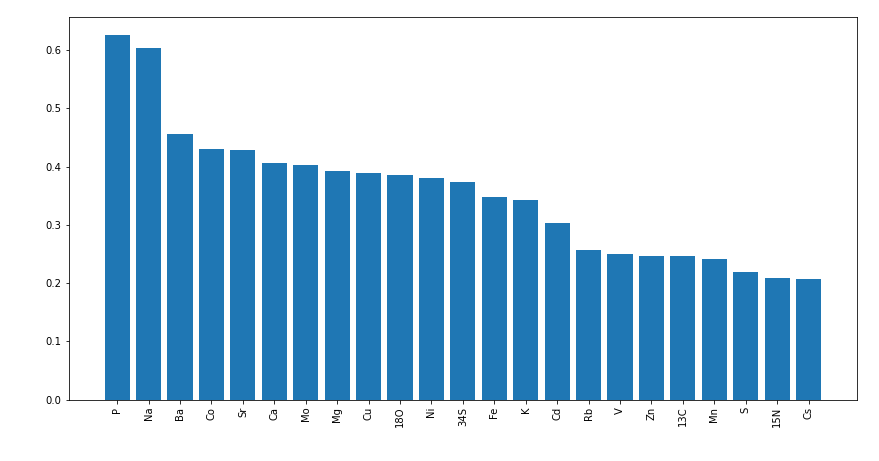

FixedFormatter should only be used together with FixedLocator


In [95]:
# It looks like Na is also a unique "fingerprint" of the Authentic Slovenian strawberries
# This is very similar to the RF importances we previously calculated (same top 3)
jsd.visualize(by_class=False, classes=np.unique(y_train))

<IPython.core.display.Javascript object>


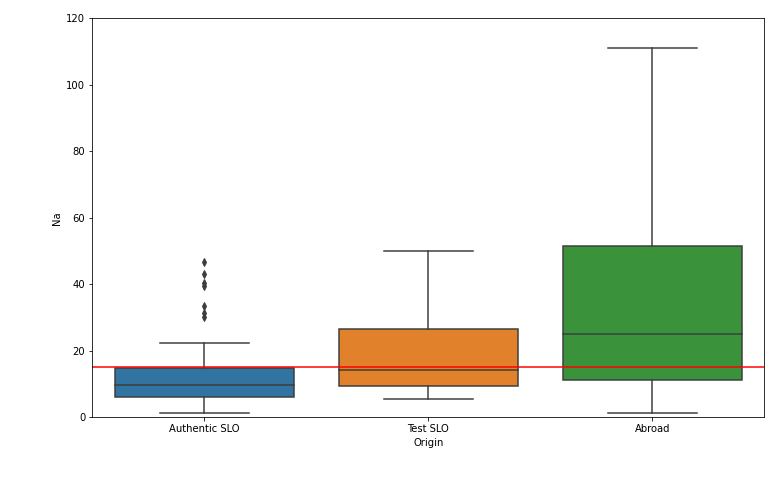

In [96]:
plt.figure()
sns.boxplot(data=df, y='Na', x='Origin')
plt.tight_layout()
plt.gca().set_ylim(0, 120) # For improved visualization

guess = 15
plt.axhline(guess, color='r') # Just a guess for visualization

<IPython.core.display.Javascript object>


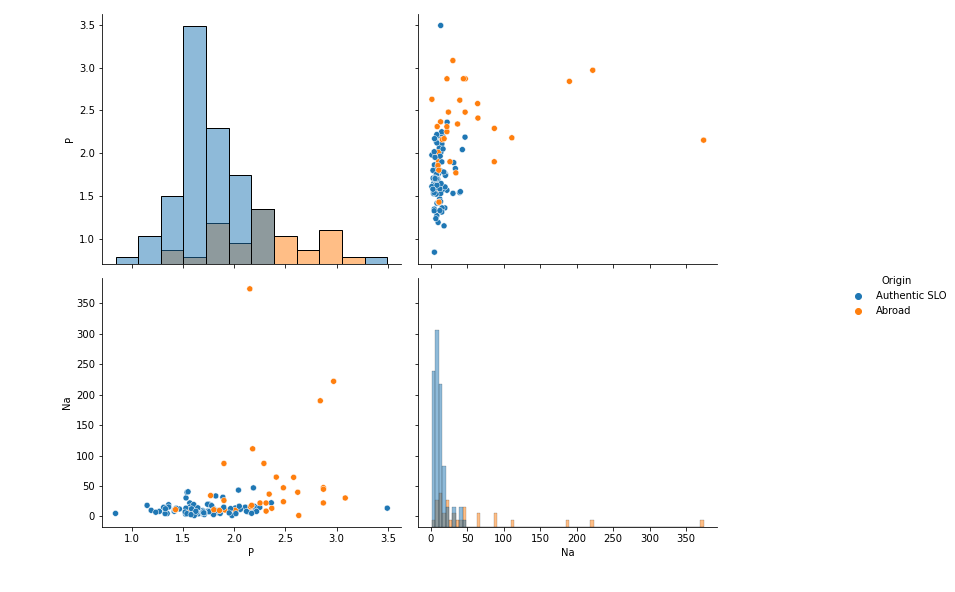

In [97]:
# Na seems very sparse and maybe not as reliable as P
sns.pairplot(df_trim, 
             vars=['P', 'Na'],
             diag_kind='hist', #kde
             hue='Origin')

In [108]:
# Can we train a tree based on Na and P only?

na_idx = np.where(df_trim.drop(['Origin'], axis=1).columns == 'Na')[0][0]
p_idx = np.where(df_trim.drop(['Origin'], axis=1).columns == 'P')[0][0]

X_revised_train = np.hstack((X_train[:,na_idx].reshape(-1,1), X_train[:,p_idx].reshape(-1,1)))
X_revised_test = np.hstack((X_test[:,na_idx].reshape(-1,1), X_test[:,p_idx].reshape(-1,1)))

In [125]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best'], #, 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[1, 3, 5, 10, 20],
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Y/N class balancing turns out to affect performance
    'dt__random_state':[42]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5,  
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(
    X_revised_train, 
    y_train
)

In [126]:
gs.best_params_ # Depth 3 suggests a 3D "cube" we can find the Auth SLO in (visually consistent with 3D PCA)

{'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': 3,
 'dt__min_samples_leaf': 3,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

<IPython.core.display.Javascript object>


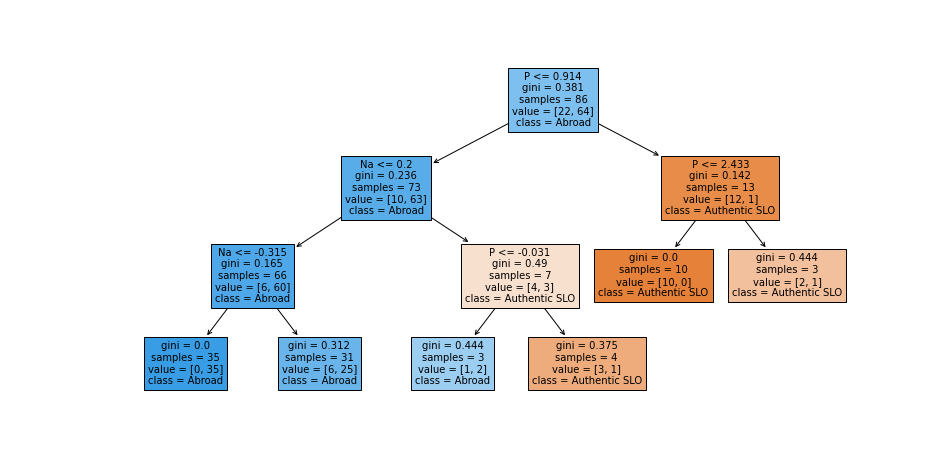

In [127]:
fig = plt.figure()
_ = tree.plot_tree(gs.best_estimator_.named_steps['dt'], 
                   feature_names=['Na', 'P'],  
                   class_names=['Authentic SLO', 'Abroad'],
                   impurity=True,
                   proportion=False,
                   fontsize=10,
                   filled=True)

In [128]:
gs.score(X_revised_train, y_train)

0.8953488372093024

In [129]:
gs.score(X_revised_test, y_test) 

# Not too bad given this is just a decision tree
# The tree based ONLY on P seemed to do better - this reflects uncertainty due to fixed test set
# Changing the k in kfold also changes this number by ~5% consistent with this

0.8421052631578947

<IPython.core.display.Javascript object>


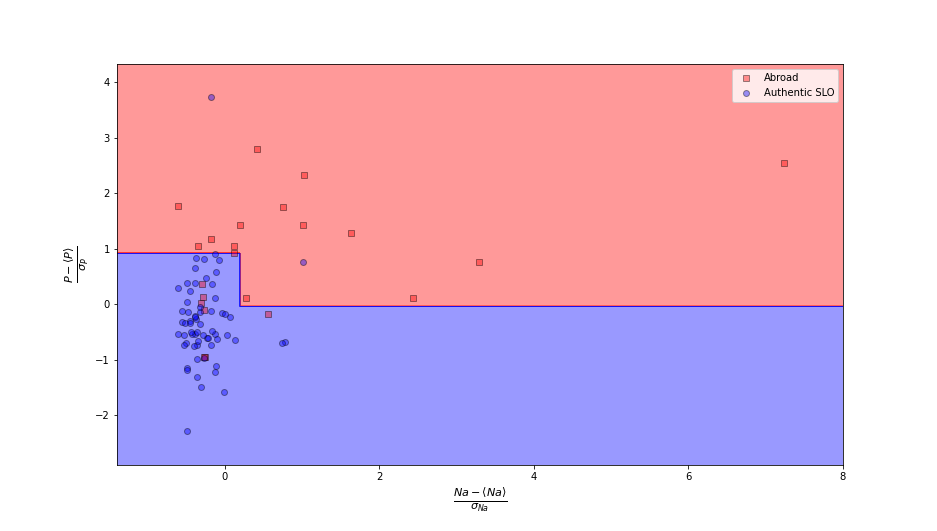

In [131]:
plt.figure()
plot_decision_region(gs, X_revised_train, y_train)
_ = plt.ylabel(r'$\frac{P - \langle P \rangle}{\sigma_P}$', fontsize=16)
_ = plt.xlabel(r'$\frac{Na - \langle Na \rangle}{\sigma_{Na}}$', fontsize=16)

<IPython.core.display.Javascript object>


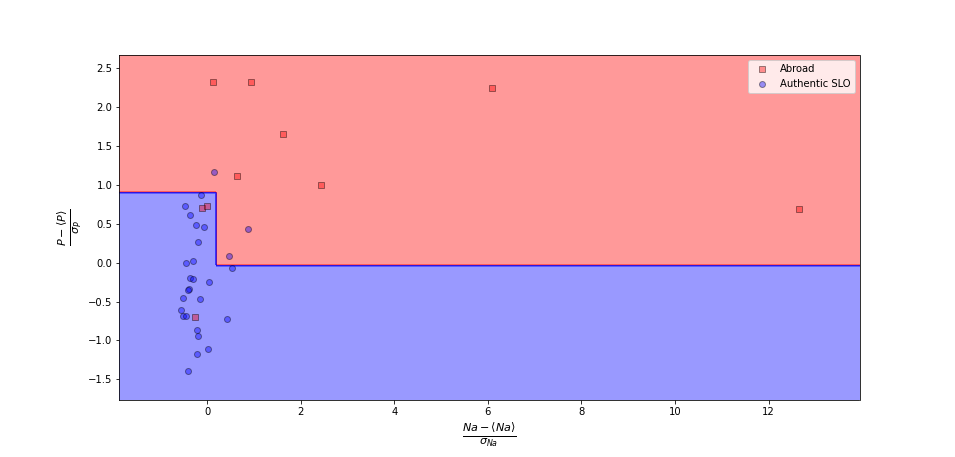

In [132]:
plt.figure()
plot_decision_region(gs, X_revised_test, y_test)
_ = plt.ylabel(r'$\frac{P - \langle P \rangle}{\sigma_P}$', fontsize=16)
_ = plt.xlabel(r'$\frac{Na - \langle Na \rangle}{\sigma_{Na}}$', fontsize=16)

In [133]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("rf", RandomForestClassifier(n_estimators=1.0))
])

param_grid = [{
    'rf__n_estimators':[1, 5, 10, 100, 200],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 3, 5, 10, 20, None],
    'rf__min_samples_leaf':[1, 3],
    'rf__class_weight':['balanced', 'balanced_subsample', None],
    'rf__random_state':[42]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(
    X_revised_train, 
    y_train
)

In [134]:
gs.best_params_

{'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': 3,
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 200,
 'rf__random_state': 42}

In [135]:
gs.score(X_revised_train, y_train)

0.9186046511627907

In [136]:
# Almost as good as RF with all the features! Still worse than single trees though.
# Seems to be overfitting training set (train score is higher on RF but test score lower relative to DT)
gs.score(X_revised_test, y_test) 

0.8157894736842105

In [137]:
# The forest uses Na and P information about equally
forest = gs.best_estimator_.named_steps['rf']
columns = ['Na', 'P']
importances = sorted(list(zip(columns, forest.feature_importances_)), key=lambda x:x[1], reverse=True)
importances

[('P', 0.5434661405467767), ('Na', 0.4565338594532234)]

<IPython.core.display.Javascript object>


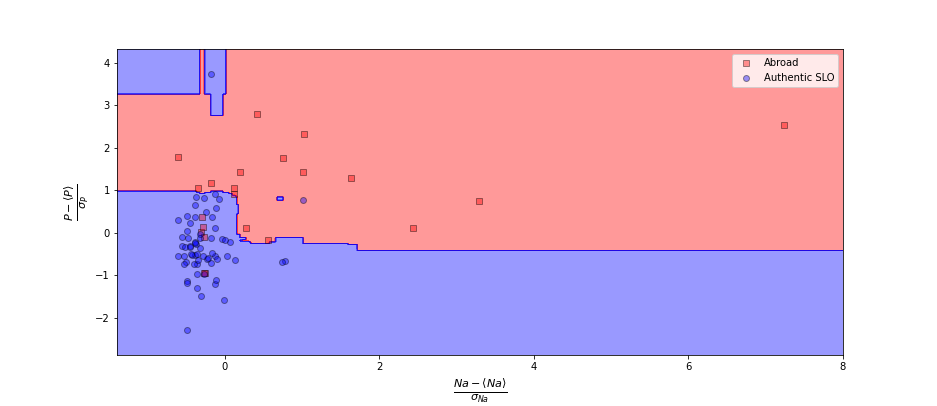

In [138]:
plt.figure()
plot_decision_region(gs, X_revised_train, y_train)
_ = plt.ylabel(r'$\frac{P - \langle P \rangle}{\sigma_P}$', fontsize=16)
_ = plt.xlabel(r'$\frac{Na - \langle Na \rangle}{\sigma_{Na}}$', fontsize=16)

<IPython.core.display.Javascript object>


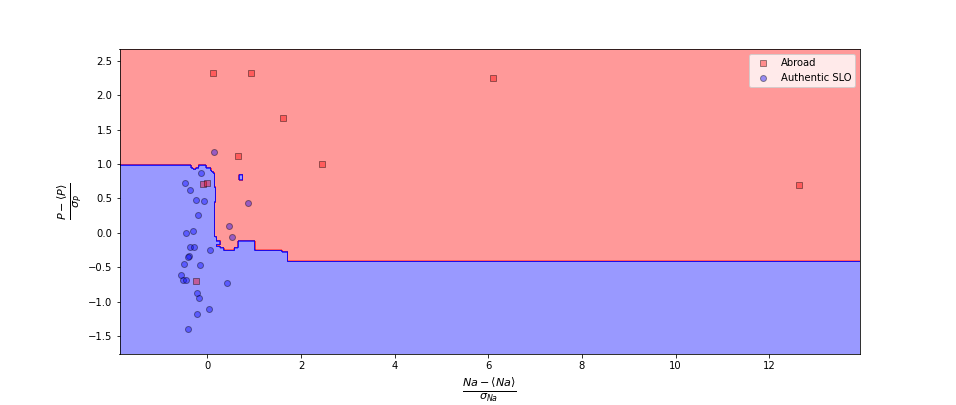

In [139]:
plt.figure()
plot_decision_region(gs, X_revised_test, y_test, resolution=0.02)
_ = plt.ylabel(r'$\frac{P - \langle P \rangle}{\sigma_P}$', fontsize=16)
_ = plt.xlabel(r'$\frac{Na - \langle Na \rangle}{\sigma_{Na}}$', fontsize=16)

# PLS-DA (Soft)

In [385]:
from pychemauth.classifier.plsda import PLSDA

In [403]:
# PLS-DA model for Authentic vs. Abroad

pipeline = imblearn.pipeline.Pipeline(steps=[
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

param_grid = [{
    'plsda__n_components':np.arange(1, 20, 2),
    'plsda__alpha': [0.05, 0.01], # Try a few alpha values to see
    'plsda__scale_x': [True], # SITE data makes sense to standardize
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=5, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, [rename(y) for y in y_train])

In [404]:
gs.best_params_

{'plsda__alpha': 0.05, 'plsda__n_components': 3, 'plsda__scale_x': True}

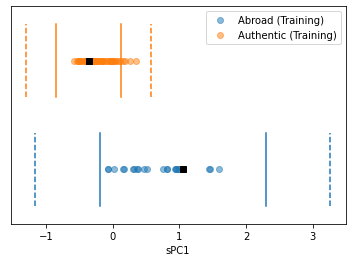

In [406]:
gs.best_estimator_.named_steps['plsda'].visualize(styles=['soft'])
# plt.savefig('fig4.png', dpi=300, bbox_inches='tight')

In [395]:
pred = gs.predict(X_test)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(pred, [rename(y) for y in y_test])

In [396]:
df

,Abroad,Authentic,UNKNOWN
Abroad,8,3,1
Authentic,13,25,0


In [397]:
TEFF # A little worse than SIMCA which was ~ 0.76

0.7090628202793411

In [398]:
TSNS # Akin to "accuracy" in other discrimination models - to me this suggests the PLS-DA is about the same as others
# However, the TEFF (which incorporates specificity) suggests the "softness" makes it a bit worse

0.868421052631579

In [399]:
TSPS

0.5789473684210527

In [400]:
CSNS

Abroad       0.800000
Authentic    0.892857
dtype: float64

In [401]:
CSPS

Abroad       0.535714
Authentic    0.700000
dtype: float64

# Statistically Compare Pipelines

In [150]:
from ml_inspector.model import Compare
from ml_utils.sklearn_ext.cross_validation import NestedCV
from sklearn.preprocessing import StandardScaler

from pychemauth.classifier.simca import SIMCA_Classifier
from pychemauth.classifier.plsda import PLSDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [151]:
# Raw data, max LOD imputation, ignoring analytes with > 20% missing
df = impute_by_max(raw_df.drop(bad_analytes, axis=1), 
            lod_df, 
            impute_elements.drop(bad_analytes)
           ) 
df_trim = df[(df['Origin'] == 'Authentic SLO') | (df['Origin'] == 'Abroad')].drop(['Harvest year', 'Country'], axis=1)
df_unknown = df[(df['Origin'] == 'Test SLO')].drop(['Harvest year', 'Country'], axis=1)

X_raw = df_trim.drop(['Origin'], axis=1).values
y_raw = df_trim['Origin'].values

X_unknown = df_unknown.drop(['Origin'], axis=1).values
y_unknown = df_unknown['Origin'].values

# Sometimes consider only P and Na
p_idx = np.where(df_trim.drop(['Origin'], axis=1).columns == 'P')[0][0]
na_idx = np.where(df_trim.drop(['Origin'], axis=1).columns == 'Na')[0][0]

# Select folds
k_inner = 3
k_outer = 5

# Compare different models on TEST SLO dataset
final_models = {}

def final_fit(X, y, pipeline, param_grid):
    """CV on entire dataset, retrain on full set at the end."""
    
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=5, 
            shuffle=True, 
            random_state=0,
        ),
        error_score=0,
        refit=True # Re-fit the model on the entire dataset
    )
    
    gs.fit(X, y) 
    
    return gs

# Include autoscaling in pipeline now
def get_nested_scores(pipeline, param_grid, X, y, k_inner=2, k_outer=5):
    NCV = NestedCV(k_inner=k_inner, k_outer=k_outer)
    return NCV.grid_search(pipeline, param_grid, X, y, classification=True)

## Final Model Performances

In [152]:
# 1. SVC
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(C=1.0))
])

param_grid = [{
    'svc__C':[0.01, 0.1, 1.0, 10.0, 100.0],
    'svc__kernel':['rbf', 'poly', 'linear', 'sigmoid'],
    'svc__gamma':['auto', 'scale'],
    'svc__coef0':[0.01, 0.1, 1.0, 10.0, 100.0],
    'svc__degree':[1, 2, 3, 4, 5],
    'svc__shrinking':[True, False],
    'svc__class_weight':['balanced', None],
    'svc__random_state':[42]
}]

svc_scores = get_nested_scores(pipeline, param_grid, X_raw, y_raw, k_inner=k_inner, k_outer=k_outer)

In [153]:
final_models['SVC'] = final_fit(X=X_raw, y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [154]:
svc_scores

array([0.87878788, 0.84848485, 0.90909091, 0.84848485, 0.87878788,
       0.90909091, 0.87878788, 0.90909091, 0.81818182, 0.84848485,
       0.93939394, 0.87878788, 0.85294118, 0.87878788, 0.93939394])

In [155]:
# 2. RF with all SITE - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("rf", RandomForestClassifier(n_estimators=1.0))
])

param_grid = [{
    'rf__n_estimators':[5, 10, 100, 200],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 3, 5, 10, 20, None],
    'rf__min_samples_leaf':[1, 3],
    'rf__class_weight':['balanced', 'balanced_subsample', None],
    'rf__random_state':[42]
}]

rf_all_scores = get_nested_scores(pipeline, param_grid, X_raw, y_raw, k_inner=k_inner, k_outer=k_outer)

In [156]:
final_models['RF'] = final_fit(X=X_raw, y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [157]:
rf_all_scores

array([0.93939394, 0.81818182, 0.90909091, 0.84848485, 0.84848485,
       0.90909091, 0.84848485, 0.93939394, 0.84848485, 0.81818182,
       0.87878788, 0.81818182, 0.85294118, 0.84848485, 0.90909091])

In [158]:
# 3. RF with just (P and Na) - scaling not necessary but for consistency we will do it here
column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True
rf_p_na_scores = get_nested_scores(pipeline, param_grid, X_raw[:,column_mask], y_raw, k_inner=k_inner, k_outer=k_outer)

In [159]:
final_models['RF (P, Na)'] = final_fit(X=X_raw[:,column_mask], 
                                       y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [160]:
rf_p_na_scores

array([0.84848485, 0.78787879, 0.96969697, 0.84848485, 0.84848485,
       0.87878788, 0.84848485, 0.87878788, 0.90909091, 0.84848485,
       0.78787879, 0.90909091, 0.85294118, 0.78787879, 0.96969697])

In [161]:
# 4. DT stump with P - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[1], # Let's see how just a "stump" performs
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
pipe_dt_p_stump_scores = get_nested_scores(pipeline, param_grid, 
                                           X_raw[:,column_mask], y_raw, k_inner=k_inner, k_outer=k_outer)

In [162]:
final_models['DT (P)'] = final_fit(X=X_raw[:,column_mask], 
                                   y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [163]:
pipe_dt_p_stump_scores

array([0.84848485, 0.78787879, 0.87878788, 0.78787879, 0.84848485,
       0.87878788, 0.81818182, 0.93939394, 0.87878788, 0.84848485,
       0.84848485, 0.84848485, 0.85294118, 0.75757576, 0.90909091])

In [164]:
# 5. DT stump with Na - scaling not necessary but for consistency we will do it here
column_mask = np.array([False]*X_raw.shape[1])
column_mask[na_idx] = True
pipe_dt_na_stump_scores = get_nested_scores(pipeline, param_grid, 
                                            X_raw[:,column_mask], y_raw, k_inner=k_inner, k_outer=k_outer)

In [165]:
final_models['DT (Na)'] = final_fit(X=X_raw[:,column_mask], 
                                    y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [166]:
pipe_dt_na_stump_scores

array([0.87878788, 0.75757576, 0.84848485, 0.75757576, 0.81818182,
       0.78787879, 0.84848485, 0.75757576, 0.93939394, 0.78787879,
       0.72727273, 0.81818182, 0.76470588, 0.75757576, 0.81818182])

In [167]:
# 6. DT with P and Na - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[3, 5, 10, 20], # Dis-allow stump since tested elsewhere
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True
dt_p_na_scores = get_nested_scores(pipeline, param_grid, 
                                   X_raw[:,column_mask], y_raw, k_inner=k_inner, k_outer=k_outer)

In [168]:
final_models['DT (P, Na)'] = final_fit(X=X_raw[:,column_mask], 
                                       y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [169]:
dt_p_na_scores

array([0.84848485, 0.78787879, 0.90909091, 0.84848485, 0.81818182,
       0.93939394, 0.81818182, 0.84848485, 0.93939394, 0.84848485,
       0.81818182, 0.84848485, 0.88235294, 0.78787879, 0.90909091])

In [170]:
# 7. DD-SIMCA
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("simca", SIMCA_Classifier(n_components=7, 
                                alpha=0.05, 
                                scale_x=True, 
                                style='dd-simca', 
                                target_class="Authentic SLO", 
                                use='TEFF')
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 20, 2),
    'simca__alpha':[0.05],
    'simca__style':['dd-simca'],
    'simca__scale_x':[True]
}]

simca_scores = get_nested_scores(pipeline, param_grid, X_raw, y_raw, k_inner=k_inner, k_outer=k_outer)

In [171]:
final_models['DD-SIMCA'] = final_fit(X=X_raw, y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [172]:
simca_scores

array([0.72456884, 0.70710678, 0.78173596, 0.75828754, 0.74224385,
       0.76376262, 0.67082039, 0.77136243, 0.86066297, 0.69282032,
       0.63245553, 0.86334835, 0.6992059 , 0.69282032, 0.90267093])

In [173]:
# 8. DD-SIMCA with only P and Na
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("simca", SIMCA_Classifier(n_components=7, 
                                alpha=0.05, 
                                scale_x=True, 
                                style='dd-simca', 
                                target_class="Authentic SLO", 
                                use='TEFF')
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 20, 2),
    'simca__alpha':[0.05],
    'simca__style':['dd-simca'],
    'simca__scale_x':[True]
}]

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True
simca_scores_p_na = get_nested_scores(pipeline, param_grid, 
                                      X_raw[:,column_mask], y_raw, k_inner=k_inner, k_outer=k_outer)


27 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the nu

In [174]:
final_models['DD-SIMCA (P, Na)'] = final_fit(X=X_raw[:,column_mask], 
                                             y=y_raw, pipeline=pipeline, param_grid=param_grid)


45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the numb

In [175]:
simca_scores_p_na

array([0.678233  , 0.63828474, 0.78173596, 0.58736701, 0.79930525,
       0.78173596, 0.6       , 0.77459667, 0.74535599, 0.5       ,
       0.73484692, 0.79930525, 0.56568542, 0.72456884, 0.90267093])

In [176]:
# 9. PLS-DA
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

param_grid = [{
    'plsda__n_components':np.arange(1, 20, 2),
    'plsda__alpha': [0.05, 0.01], # Try a few alpha values to see
    'plsda__scale_x': [True], # SITE data makes sense to standardize
}]

plsda_scores = get_nested_scores(pipeline, param_grid, X_raw, y_raw, k_inner=k_inner, k_outer=k_outer)

In [177]:
final_models['PLSDA'] = final_fit(X=X_raw, y=y_raw, pipeline=pipeline, param_grid=param_grid)

In [178]:
plsda_scores

array([0.71196001, 0.84848485, 0.75514762, 0.86350345, 0.75514762,
       0.80288735, 0.75696945, 0.71066905, 0.80288735, 0.64709565,
       0.75757576, 0.78554433, 0.7487013 , 0.77257871, 0.81762046])

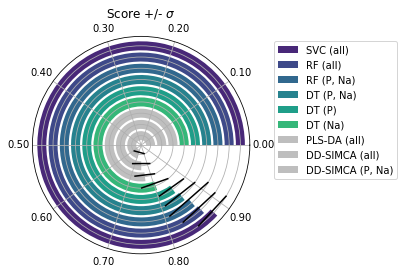

In [182]:
%matplotlib inline

results = {
    'SVC (all)': svc_scores,
    'RF (all)': rf_all_scores,
    'RF (P, Na)': rf_p_na_scores,
    'DT (P)': pipe_dt_p_stump_scores,
    'DT (Na)': pipe_dt_na_stump_scores,
    'DT (P, Na)': dt_p_na_scores,
    'PLS-DA (all)': plsda_scores,
    'DD-SIMCA (P, Na)': simca_scores_p_na,
    'DD-SIMCA (all)': simca_scores
}

plt.figure()
_ = Compare.visualize(results, k_outer, alpha=0.05)

In [183]:
# All ML pipelines are statistically indistinguishable from the best (SVC) model!

# The authentication approaches (PLS-DA and SIMCA) statistically underperform ML but this is because ML models
# are discriminators so it is not fair to compare them absolutely.  They still perform very similarly. Moreover,
# these are using TEFF not accuracy as the metric which is also different.

# The ordering also makes perfect logical sense. 
# (Most powerful (disc.) ML --> least powerful (disc.) ML --> PLS-DA (in-between) --> SIMCA (auth.))
# The DT using P and Na is my choice for the "best" model

In [184]:
# Best model is 
print('Chosen model has {} +/- {}% accuracy'.format(
    '%.1f'%(100*np.mean(results['DT (P, Na)'])), 
    '%.1f'%(100*np.std(results['DT (P, Na)'])))
     )

Chosen model has 85.7 +/- 4.8% accuracy


In [185]:
gs = final_models['DT (P, Na)']

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True

In [186]:
gs.best_params_ # Optimal model

{'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': 3,
 'dt__min_samples_leaf': 1,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

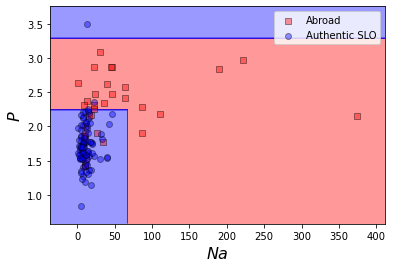

In [187]:
plt.figure()
plot_decision_region(gs, X_raw[:,column_mask], y_raw)
_ = plt.ylabel(r'$P$', fontsize=16)
_ = plt.xlabel(r'$Na$', fontsize=16)

## What about the Test SLO predictions?

In [188]:
final_models.keys()

dict_keys(['SVC', 'RF', 'RF (P, Na)', 'DT (P)', 'DT (Na)', 'DT (P, Na)', 'DD-SIMCA', 'DD-SIMCA (P, Na)', 'PLSDA'])

In [189]:
predictions = {}
for k, model in final_models.items():
    column_mask = np.array([False]*X_raw.shape[1])
    if '(P, Na)' in k:
        column_mask[p_idx] = True
        column_mask[na_idx] = True 
    elif '(P)' in k:
        column_mask[p_idx] = True
    elif '(Na)' in k:
        column_mask[na_idx] = True 
    else:
        column_mask = np.array([True]*X_raw.shape[1])
    predictions[k] = model.predict(X_unknown[:,column_mask])

In [190]:
 predictions

{'SVC': array(['Abroad', 'Authentic SLO', 'Abroad', 'Abroad', 'Abroad',
        'Authentic SLO', 'Authentic SLO', 'Abroad', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Abroad',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO'],
       dtype=object),
 'RF': array(['Abroad', 'Authentic SLO', 'Abroad', 'Abroad', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Abroad', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Abroad',
        'Authentic SLO', 'Authentic SLO', 'Authentic SLO', 'Authentic SLO',
        'Authentic 

In [191]:
ml_models = ['SVC', 'RF', 'RF (P, Na)', 'DT (P)', 'DT (Na)', 'DT (P, Na)']

In [192]:
# Let's look at how consistently ML models predict Test SLO points
perf = []
for i in range(X_unknown.shape[0]):
    auth = [predictions[m][i] == 'Authentic SLO' for m in ml_models]
    perf.append([np.sum(auth), np.std(auth)])
perf = np.array(perf)    

consensus_authentic = perf[:,0] > len(ml_models)/2. # Majority say it is authentic
consensus_foreign = perf[:,0] < len(ml_models)/2. # Majority say it is authentic

In [193]:
perf # First column is number of models which predict it is authentic, second is std. dev.

array([[3.        , 0.5       ],
       [6.        , 0.        ],
       [0.        , 0.        ],
       [1.        , 0.372678  ],
       [4.        , 0.47140452],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [0.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [5.        , 0.372678  ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [1.        , 0.372678  ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [5.        , 0.372678  ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [1.        , 0.372678  ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [6.        , 0.        ],
       [5.        , 0.372678  ],
       [6.        , 0.        ],
       [6.

In [194]:
consensus_authentic

array([False,  True, False, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [195]:
consensus_foreign

array([False, False,  True,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False])

In [196]:
(~consensus_authentic) & (~consensus_foreign) # There is one right "on the border"

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [197]:
# Most ML models agree with each other!
# Usually all models agree (6/6 are 1 or 0 so std==0).
# 7 samples have a 5 to 1 split
# 1 is 3 vs. 3, and 1 is 4 vs. 2

In [198]:
# Let's look at just the models trained on (P, Na) including DD-SIMCA
models_used = ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']

# Let's look at how consistently these models predict Test SLO points
perf = []
for i in range(X_unknown.shape[0]):
    auth = [(predictions[m][i] == 'Authentic SLO') or (predictions[m][i] == True) for m in models_used]
    perf.append([np.sum(auth), np.std(auth), [m for m in models_used if (predictions[m][i] == 'Authentic SLO') 
                                              or (predictions[m][i] == True)]])

In [199]:
perf

[[3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [1, 0.4714045207910317, ['DD-SIMCA (P, Na)']],
 [1, 0.4714045207910317, ['DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [0, 0.0, []],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA (P, Na)']],
 [1, 0.4714045207910317, ['DD-SIMCA (P, Na)']],
 [3, 0.0, ['RF (P, Na)', 'DT (P, Na)', 'DD-SIMCA

In [205]:
np.sum([p[0]==3 for p in perf])

26

In [206]:
# Most of the time DD-SIMCA and RF/DT agree.
# DT and RF always make the same predictions on this set.

# 26 agreed to be authentic SLO by all models
# 2 that are agreed to be foreign by all models
# in 3 cases, DD-SIMCA thinks a sample is authentic but the trees do not
# in 2 cases, the trees think it is authentic, but DD-SIMCA does not
# So about evenly split...

In [207]:
# final_models['RF (P, Na)'].predict_proba(X_unknown[:,column_mask])

In [208]:
# final_models['DT (P, Na)'].predict_proba(X_unknown[:,column_mask])

In [209]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

def plot_decision_region_compare(clf, X, y, resolution=0.02, show_train=True, show_unknown=True):
    markers = ('s', 'o', '^', 'v')
    colors = ('r', 'b', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # These pipelines all have a scaler on them
    X = clf.best_estimator_.named_steps['scaling'].transform(X)
    
    x1_min, x1_max = X[:,0].min(), X[:,0].max()
    dx = 0.1*(x1_max - x1_min)
    x1_min -= dx
    x1_max += dx
    
    x2_min, x2_max = X[:,1].min(), X[:,1].max()
    dx = 0.1*(x2_max - x2_min)
    x2_min -= dx
    x2_max += dx
    
    enc = LabelEncoder()
    enc.fit(y)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    # Pipelines need to see an unscaled input
    Z = clf.predict(clf.best_estimator_.named_steps['scaling'].inverse_transform(
        np.array([xx1.ravel(), xx2.ravel()]).T)
                   )
    Z = enc.transform(Z).reshape(xx1.shape)
    
    # Plot in the transformed space
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    if show_train:
        # Training (entire dataset)
        for idx, c1 in enumerate(np.unique(y)):
            plt.scatter(x=X[y==c1, 0], y=X[y==c1, 1], alpha=0.25, c=colors[idx], edgecolor='black', marker='.', label=c1)
        
    if show_unknown:
        # Unknown results
        X_u = clf.best_estimator_.named_steps['scaling'].transform(X_unknown[:, column_mask])
    
        all_auth_mask = np.array([p[0] == 3 for p in perf])
        plt.scatter(x=X_u[all_auth_mask, 0], 
                    y=X_u[all_auth_mask, 1], 
                    alpha=1, 
                    c='k', 
                    edgecolor='black', 
                    marker='*', 
                    label='All Authentic')

        all_foreign_mask = np.array([p[0] == 0 for p in perf])
        plt.scatter(x=X_u[all_foreign_mask, 0], 
                    y=X_u[all_foreign_mask, 1], 
                    alpha=1, 
                    c='k', 
                    edgecolor='black', 
                    marker='s', 
                    label='All Foreign')

        simca_auth_mask = np.array([p[2] == ['DD-SIMCA (P, Na)'] for p in perf])
        plt.scatter(x=X_u[simca_auth_mask, 0], 
                    y=X_u[simca_auth_mask, 1], 
                    alpha=1, 
                    c='magenta', 
                    edgecolor='black', 
                    marker='<', 
                    label='DD-SIMCA Only Auth.')

        tree_auth_mask = np.array([p[2] == ['RF (P, Na)', 'DT (P, Na)'] or 
                                   p[2] == ['DT (P, Na)', 'RF (P, Na)']
                                   for p in perf])
        plt.scatter(x=X_u[tree_auth_mask, 0], 
                    y=X_u[tree_auth_mask, 1], 
                    alpha=1, 
                    c='cyan', 
                    edgecolor='black', 
                    marker='>', 
                    label='Tree Only Auth.')
        
        other_auth_mask = np.array([p[2] == ['DD-SIMCA (P, Na)', 'RF (P, Na)'] or
                                    p[2] == ['RF (P, Na)', 'DD-SIMCA (P, Na)']
                                    for p in perf])
        plt.scatter(x=X_u[other_auth_mask, 0], 
                    y=X_u[other_auth_mask, 1], 
                    alpha=1, 
                    c='yellow', 
                    edgecolor='black', 
                    marker='v', 
                    label='DD/RF Only Auth.')
        
        dt_auth_mask = np.array([p[2] == ['DT (P, Na)'] for p in perf])
        plt.scatter(x=X_u[dt_auth_mask, 0], 
                    y=X_u[dt_auth_mask, 1], 
                    alpha=1, 
                    c='orange', 
                    edgecolor='black', 
                    marker='^', 
                    label='DT Only Auth.')
    
    plt.legend(loc='best')
    

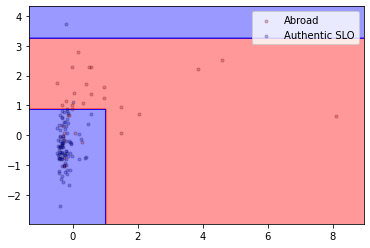

In [210]:
column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True

plot_decision_region_compare(final_models['DT (P, Na)'], X_raw[:,column_mask], y_raw, show_unknown=False)

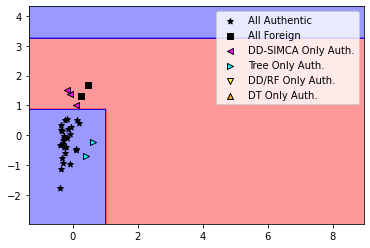

In [211]:
plot_decision_region_compare(final_models['DT (P, Na)'], X_raw[:,column_mask], y_raw, show_train=False)

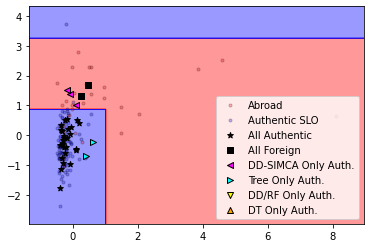

In [212]:
plot_decision_region_compare(final_models['DT (P, Na)'], X_raw[:,column_mask], y_raw)

In [213]:
# Since there are some Abroad samples in the blue region, the "cyan" triangles where SIMCA lists these as Abroad are
# understandable - also the blue/red vertical line could conceivably be shifted to the left to end up in agreement
# so I don't think the SIMCA model should be "penalized" too much for considering these to be foreign.  However,
# the lower example does fall right on top of training samples which are known to be authentic, so it is not really
# good that these are predicted to be foreign since they are almost certainly authentic examples.

# The "magenta" triangles where the SIMCA model thinks they ARE authentic are in a region where there are really 
# no examples of authentic samples from the dataset, so I think this is an incorrect prediction.  Part of this may 
# be due to the inclusion of the "outlier" at the top of the figure.  Usually, iterative outlier removal is performed 
# to "clean" the dataset.

# However, DT and JSD are how we arrived at this (P, Na) to begin with.
# In the end, SIMCA and DT are about the same

# Note the "outlier" at the top of the plot seems to be "stretching" the decision boundary for DD-SIMCA "up".
# What happens if we remove that?

## Remove Outlier(s)

<AxesSubplot:xlabel='${\\rm ln(1 + h/h_0)}$', ylabel='${\\rm ln(1 + q/q_0)}$'>

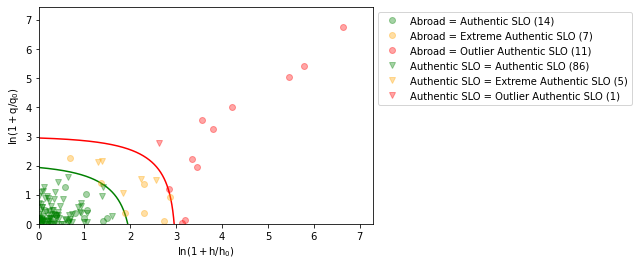

In [214]:
final_models['DD-SIMCA (P, Na)'].best_estimator_.named_steps['simca'].model.visualize(
    X_raw[:, column_mask], y_raw)

In [215]:
# We have 1 outliers from the Authentic SLO set
X_ = X_raw[y_raw == "Authentic SLO"][:, column_mask]
outliers = final_models['DD-SIMCA (P, Na)'].best_estimator_.named_steps['simca'].model.distance(X_) > final_models['DD-SIMCA (P, Na)'].best_estimator_.named_steps['simca'].model._DDSIMCA_Model__c_out_
final_models['DT (P, Na)'].best_estimator_.named_steps['scaling'].transform(X_[outliers])

# Indeed, this visually corresponds to the "top blue" one above

array([[-0.21816501,  3.72565738]])

In [216]:
# Let's try to remove outliers from training set in an iterative fashion

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True

import copy
model = copy.deepcopy(final_models['DD-SIMCA (P, Na)'].best_estimator_.named_steps['simca'])
X_ = X_raw[:, column_mask]
y_ = y_raw

model.fit(X_, y_)

extremes, outliers = model.model.check_outliers(X_)

for round_ in range(1, 10):
    mask = outliers & (y_ == 'Authentic SLO') # Only remove outliers which are NOT Abroad (supposed to be "outliers")
    if np.sum(mask) == 0:
        break
    else:
        X_ = X_[~mask]
        y_ = y_[~mask]

        model.fit(X_, y_)
        extremes, outliers = model.model.check_outliers(X_)
        print('Round {}: Found {} extremes and Auth. SLO {} outliers'.format(round_, np.sum(extremes), 
                                                                             np.sum(mask)))
        outlier_mask = mask.copy()

Round 1: Found 11 extremes and Auth. SLO 1 outliers


<AxesSubplot:xlabel='${\\rm ln(1 + h/h_0)}$', ylabel='${\\rm ln(1 + q/q_0)}$'>

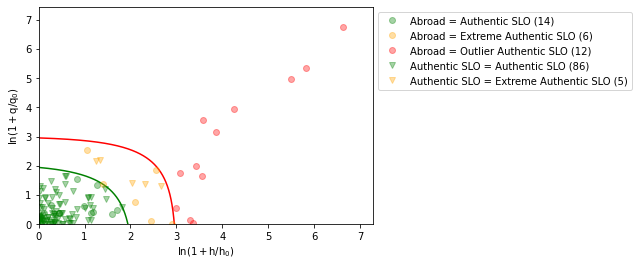

In [217]:
# Removing the one outlier yielded a "clean" data set after 1 round
model.model.visualize(
    X_, y_)

In [218]:
# Let's repeat this comparison but train our models with the revised dataset

revised_final = {}

# 1. DD-SIMCA with only P and Na
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("simca", SIMCA_Classifier(n_components=7, 
                                alpha=0.05, 
                                scale_x=True, 
                                style='dd-simca', 
                                target_class="Authentic SLO", 
                                use='TEFF')
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 20, 2),
    'simca__alpha':[0.05],
    'simca__style':['dd-simca'],
    'simca__scale_x':[True]
}]

revised_final['DD-SIMCA (P, Na)'] = final_fit(X=X_, y=y_, pipeline=pipeline, param_grid=param_grid)

# 2. DT with P and Na - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[3, 5, 10, 20], # Dis-allow stump since tested elsewhere
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

revised_final['DT (P, Na)'] = final_fit(X=X_, y=y_, pipeline=pipeline, param_grid=param_grid)

# 3. RF with all SITE - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("rf", RandomForestClassifier(n_estimators=1.0))
])

param_grid = [{
    'rf__n_estimators':[5, 10, 100, 200],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 3, 5, 10, 20, None],
    'rf__min_samples_leaf':[1, 3],
    'rf__class_weight':['balanced', 'balanced_subsample', None],
    'rf__random_state':[42]
}]

revised_final['RF (P, Na)'] = final_fit(X=X_, y=y_, pipeline=pipeline, param_grid=param_grid)


45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the numb

In [219]:
predictions = {}
for k, model in revised_final.items():
    predictions[k] = model.predict(X_unknown[:,column_mask])

# Let's look at how consistently these models predict Test SLO points
perf = []
for i in range(X_unknown.shape[0]):
    auth = [(predictions[m][i] == 'Authentic SLO') or (predictions[m][i] == True) for m in predictions.keys()]
    perf.append([np.sum(auth), np.std(auth), [m for m in predictions.keys() if 
                                              (predictions[m][i] == 'Authentic SLO') 
                                              or (predictions[m][i] == True)]])

In [220]:
perf

[[3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [2, 0.4714045207910317, ['DD-SIMCA (P, Na)', 'RF (P, Na)']],
 [0, 0.0, []],
 [0, 0.0, []],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [0, 0.0, []],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [2, 0.4714045207910317, ['DD-SIMCA (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [0, 0.0, []],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [2, 0.4714045207910317

In [221]:
# Note that the "pairing" of the RF and DT is broken!  Now it seems like the SIMCA model is similar to the RF,
# but not always (still have 1 RF/DT example). Overall, the DD-SIMCA agrees mostly with the RF!

# 22 all models predict authentic
# 5 all models predict foreign
# 4 DD-SIMCA/RF agree authentic
# 1 DD-SIMCA/RF agree foreign (only DT says authentic)
# 1 DT/RF agree authentic

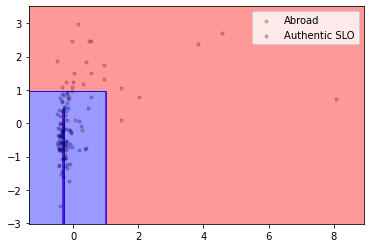

In [222]:
plot_decision_region_compare(revised_final['DT (P, Na)'], X_, y_, resolution=0.02, 
                             show_train=True, 
                             show_unknown=False)

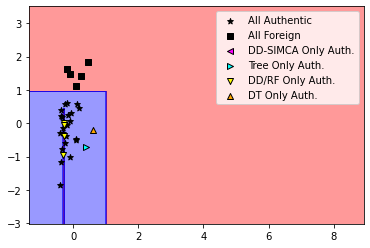

In [223]:
plot_decision_region_compare(revised_final['DT (P, Na)'], X_, y_, resolution=0.02, 
                             show_train=False, 
                             show_unknown=True)

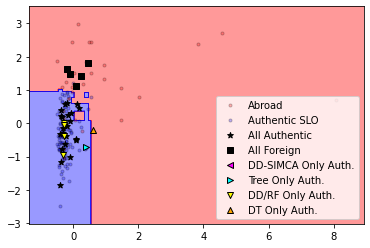

In [224]:
plot_decision_region_compare(revised_final['RF (P, Na)'], X_, y_, resolution=0.01, 
                             show_train=True, 
                             show_unknown=True)

In [225]:
# This points to the importance of removing outliers / cleaning the data first.  SIMCA has this "baked in" but 
# in principle you can do this with isolation forests, etc. or other methods to make this compatible with
# other models.  Although we do not know the ground truth for these samples, dd-SIMCA appears to mostly agree
# with a RF which is considered "state of the art" for tabular data!  OF course, whether this is really an outlier
# or we just have insufficient sampling is the question.

In [226]:
# However, it is clear the DT looks a little overfit (depth == 5)
revised_final['DT (P, Na)'].best_params_

{'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 5,
 'dt__min_samples_leaf': 2,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

In [227]:
# Re-train the tree to be more shallow
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[2,3,4], # < 5 now
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

revised_final['DT (P, Na)'] = final_fit(X=X_, y=y_, pipeline=pipeline, param_grid=param_grid)

In [228]:
predictions = {}
for k, model in revised_final.items():
    predictions[k] = model.predict(X_unknown[:,column_mask])

# Let's look at how consistently these models predict Test SLO points
perf = []
for i in range(X_unknown.shape[0]):
    auth = [(predictions[m][i] == 'Authentic SLO') or (predictions[m][i] == True) for m in predictions.keys()]
    perf.append([np.sum(auth), np.std(auth), [m for m in predictions.keys() if 
                                              (predictions[m][i] == 'Authentic SLO') 
                                              or (predictions[m][i] == True)]])

In [229]:
perf

[[3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [0, 0.0, []],
 [0, 0.0, []],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [0, 0.0, []],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [0, 0.0, []],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [3, 0.0, ['DD-SIMCA (P, Na)', 'DT (P, Na)', 'RF (P, Na)']],
 [2, 0.4714045207910317, 

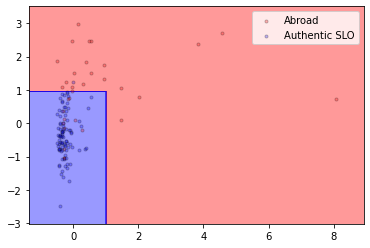

In [230]:
plot_decision_region_compare(revised_final['DT (P, Na)'], X_, y_, resolution=0.02, 
                             show_train=True, 
                             show_unknown=False)

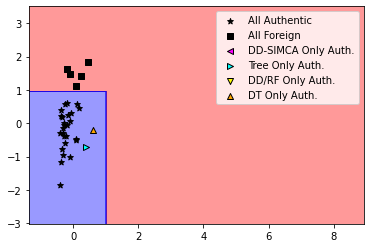

In [231]:
plot_decision_region_compare(revised_final['DT (P, Na)'], X_, y_, resolution=0.02, 
                             show_train=False, 
                             show_unknown=True)

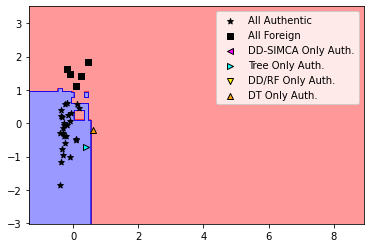

In [232]:
plot_decision_region_compare(revised_final['RF (P, Na)'], X_, y_, resolution=0.02, 
                             show_train=False, 
                             show_unknown=True)

In [233]:
# All three 3 models now agree almost all the time! The disagreements clearly occur near boundaries which are
# subjective and ultimately will depend on training data.  While this seems like a redemption of SIMCA, recall that 
# it is not very good on the training set still (Authentic vs. Abroad).

# Repeat complete comparison with outliers removed

In [234]:
X_no_out = X_raw[~outlier_mask,:]
y_no_out = y_raw[~outlier_mask]

In [235]:
final_models = {}

In [236]:
# 1. SVC
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(C=1.0))
])

param_grid = [{
    'svc__C':[0.01, 0.1, 1.0, 10.0, 100.0],
    'svc__kernel':['rbf', 'poly', 'linear', 'sigmoid'],
    'svc__gamma':['auto', 'scale'],
    'svc__coef0':[0.01, 0.1, 1.0, 10.0, 100.0],
    'svc__degree':[1, 2, 3, 4, 5],
    'svc__shrinking':[True, False],
    'svc__class_weight':['balanced', None],
    'svc__random_state':[42]
}]

svc_scores = get_nested_scores(pipeline, param_grid, X_no_out, y_no_out, k_inner=k_inner, k_outer=k_outer)

final_models['SVC'] = final_fit(X=X_no_out, y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [237]:
# 2. RF with all SITE - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("rf", RandomForestClassifier(n_estimators=1.0))
])

param_grid = [{
    'rf__n_estimators':[5, 10, 100, 200],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 3, 5, 10, 20, None],
    'rf__min_samples_leaf':[1, 3],
    'rf__class_weight':['balanced', 'balanced_subsample', None],
    'rf__random_state':[42]
}]

rf_all_scores = get_nested_scores(pipeline, param_grid, X_no_out, y_no_out, k_inner=k_inner, k_outer=k_outer)

In [238]:
final_models['RF'] = final_fit(X=X_no_out, y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [239]:
# 3. RF only P, Na
column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True
final_models['RF (P, Na)'] = final_fit(X=X_no_out[:,column_mask], 
                                       y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [240]:
# 4. DT stump with P - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[1], # Let's see how just a "stump" performs
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
pipe_dt_p_stump_scores = get_nested_scores(pipeline, param_grid, X_no_out[:,column_mask], y_no_out, k_inner=k_inner, k_outer=k_outer)

In [241]:
final_models['DT (P)'] = final_fit(X=X_no_out[:,column_mask], 
                                   y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [242]:
# 5. DT stump with Na - scaling not necessary but for consistency we will do it here
column_mask = np.array([False]*X_raw.shape[1])
column_mask[na_idx] = True
pipe_dt_na_stump_scores = get_nested_scores(pipeline, param_grid, X_no_out[:,column_mask], y_no_out, k_inner=k_inner, k_outer=k_outer)

In [243]:
final_models['DT (Na)'] = final_fit(X=X_no_out[:,column_mask], 
                                    y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [244]:
# 6. DT with P and Na - scaling not necessary but for consistency we will do it here
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", StandardScaler(with_mean=True, with_std=True)),
    ("dt", DecisionTreeClassifier())
])

param_grid = [{
    'dt__splitter':['best', 'random'], 
    'dt__criterion':['gini', 'entropy'],
    'dt__max_depth':[2,3,4], # Dis-allow stump since tested elsewhere but < 5
    'dt__min_samples_leaf':[1, 2, 3],
    'dt__class_weight':['balanced', None], # Class balancing turns out to be critical
    'dt__random_state':[42]
}]

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True
dt_p_na_scores = get_nested_scores(pipeline, param_grid, X_no_out[:,column_mask], y_no_out, k_inner=k_inner, k_outer=k_outer)

In [245]:
final_models['DT (P, Na)'] = final_fit(X=X_no_out[:,column_mask], 
                                       y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [246]:
# 7. DD-SIMCA
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("simca", SIMCA_Classifier(n_components=7, 
                                alpha=0.05, 
                                scale_x=True, 
                                style='dd-simca', 
                                target_class="Authentic SLO", 
                                use='TEFF')
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 20, 2),
    'simca__alpha':[0.05],
    'simca__style':['dd-simca'],
    'simca__scale_x':[True]
}]

simca_scores = get_nested_scores(pipeline, param_grid, X_no_out, y_no_out, k_inner=k_inner, k_outer=k_outer)

In [247]:
final_models['DD-SIMCA'] = final_fit(X=X_no_out, y=y_no_out, pipeline=pipeline, param_grid=param_grid)

In [248]:
# 8. DD-SIMCA with only P and Na
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("simca", SIMCA_Classifier(n_components=7, 
                                alpha=0.05, 
                                scale_x=True, 
                                style='dd-simca', 
                                target_class="Authentic SLO", 
                                use='TEFF')
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 20, 2),
    'simca__alpha':[0.05],
    'simca__style':['dd-simca'],
    'simca__scale_x':[True]
}]

column_mask = np.array([False]*X_raw.shape[1])
column_mask[p_idx] = True
column_mask[na_idx] = True
simca_scores_p_na = get_nested_scores(pipeline, param_grid, X_no_out[:,column_mask], y_no_out, k_inner=k_inner, k_outer=k_outer)


27 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the nu

In [249]:
final_models['DD-SIMCA (P, Na)'] = final_fit(X=X_no_out[:,column_mask], 
                                             y=y_no_out, pipeline=pipeline, param_grid=param_grid)


45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nam4\Anaconda3\envs\py37\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../..\pychemauth\classifier\simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../..\pychemauth\classifier\simca.py", line 761, in fit
    raise Exception("Reduce the numb

In [250]:
# 9. PLS-DA
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

param_grid = [{
    'plsda__n_components':np.arange(1, 20, 2),
    'plsda__alpha': [0.05, 0.01], # Try a few alpha values to see
    'plsda__scale_x': [True], # SITE data makes sense to standardize
}]

plsda_scores = get_nested_scores(pipeline, param_grid, X_no_out, y_no_out, k_inner=k_inner, k_outer=k_outer)

In [251]:
final_models['PLSDA'] = final_fit(X=X_no_out, y=y_no_out, pipeline=pipeline, param_grid=param_grid)

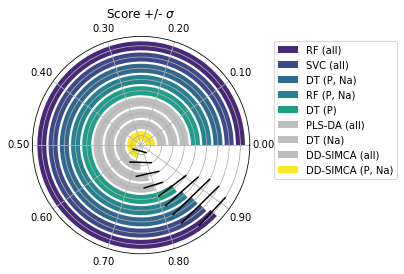

In [252]:
%matplotlib inline

results = {
    'SVC (all)': svc_scores,
    'RF (all)': rf_all_scores,
    'RF (P, Na)': rf_p_na_scores,
    'DT (P)': pipe_dt_p_stump_scores,
    'DT (Na)': pipe_dt_na_stump_scores,
    'DT (P, Na)': dt_p_na_scores,
    'PLS-DA (all)': plsda_scores,
    'DD-SIMCA (P, Na)': simca_scores_p_na,
    'DD-SIMCA (all)': simca_scores
}

plt.figure()
_ = Compare.visualize(results, k_outer, alpha=0.05)

In [253]:
# DD-SIMCA now in Rashomon set with best models! It is still a bad performer and has a very high variance
simca_scores_p_na

array([0.63828474, 0.62360956, 0.75691259, 0.47958315, 0.72966253,
       0.95742711, 0.6       , 0.80507649, 0.79056942, 0.47958315,
       0.74535599, 0.82495791, 0.56124861, 0.68041382, 0.94280904])

In [254]:
gs = final_models['DT (P, Na)']

# Best model has improved about ~3%
print('Chosen model has {} +/- {}% accuracy'.format(
    '%.1f'%(100*np.mean(results['DT (P, Na)'])), 
    '%.1f'%(100*np.std(results['DT (P, Na)'])))
     )

Chosen model has 87.2 +/- 5.5% accuracy


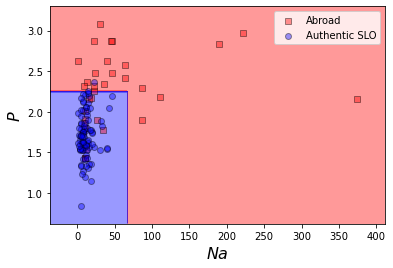

In [255]:
plt.figure()
plot_decision_region(gs, X_no_out[:, column_mask], y_no_out)
_ = plt.ylabel(r'$P$', fontsize=16)
_ = plt.xlabel(r'$Na$', fontsize=16)

In [256]:
gs.best_params_

{'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': 2,
 'dt__min_samples_leaf': 1,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

In [257]:
gs.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()),
                ('dt', DecisionTreeClassifier(max_depth=2, random_state=42))])

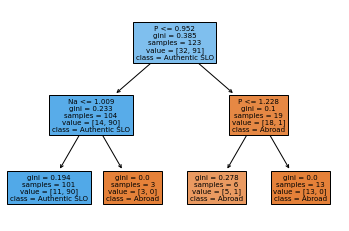

In [258]:
from sklearn import tree

fig = plt.figure()
_ = tree.plot_tree(gs.best_estimator_.named_steps['dt'], 
                   feature_names=['Na', 'P'],  
                   class_names=np.unique(y_no_out),
                   impurity=True,
                   proportion=False,
                   filled=True)

# Remember this is in scaled units

In [ ]:
# Best model is DT!

In [263]:
final_models['DD-SIMCA (P, Na)'].best_params_

{'simca__alpha': 0.05,
 'simca__n_components': 1,
 'simca__scale_x': True,
 'simca__style': 'dd-simca'}

Text(27.0, 0.5, 'TEFF')

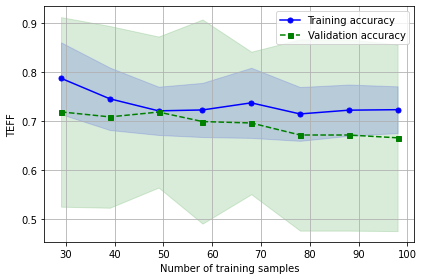

In [265]:
# SIMCA is still "saturated"

plot_lc(
    estimator=SIMCA_Classifier(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            target_class="Authentic SLO",
            use='TEFF'
        ), 
    X=X_no_out[:, column_mask], 
    y=y_no_out, 
    train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    cv=5)
plt.gca().set_ylabel('TEFF')